In [77]:
import json
import tqdm
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [13]:
keyTestTPath='data/key_test_t.csv'

In [14]:
keyTestT=pd.read_csv(keyTestTPath,usecols=['results','dimension'])

In [15]:
keyTestT=keyTestT[:50000]

In [16]:
def judgeJson(keyTestT):
    for i in tqdm.tqdm(range(len(keyTestT))):
        try:
            json.loads(keyTestT.loc[i, 'dimension'])
            json.loads(keyTestT.loc[i, 'results'])
        except:
            keyTestT.drop(i, inplace=True)
    keyTestT = keyTestT.reset_index(drop=True)
    return keyTestT

In [17]:
keyTestT=judgeJson(keyTestT)

100%|██████████| 50000/50000 [00:11<00:00, 4476.44it/s]


In [18]:
keyTestT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49505 entries, 0 to 49504
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   results    49505 non-null  object
 1   dimension  49505 non-null  object
dtypes: object(2)
memory usage: 773.6+ KB


In [87]:
# def filterDataByKey(keyTestT, keyName):
#     correctNum=0
#     for i in range(len(keyTestT)):
#         results = json.loads(keyTestT.loc[i, 'results'])
#         for result in results:
#             if keyName in result:
#                 correctNum+=1
#                 break
    # return correctNum


def filterDataByKey(keyTestT, keyName):
    correctNum=0
    for i in range(len(keyTestT)):
        results = json.loads(keyTestT.loc[i, 'results'])
        # 将resuls转为字符串，使用正则表达式判断是否包含keyName
        resultsStr = str(results)
        if re.search(keyName, resultsStr):
            correctNum+=1
    return correctNum


def getResultArgList(keyTestT,resultArgList):
    for index, row in tqdm.tqdm(keyTestT.iterrows(), total=keyTestT.shape[0]):
        result = row['results']
        resultJson = json.loads(result)
        for key in resultJson:
            if key.find('#') != -1:
                resultArgList.append(key)

    resultArgList = list(set(resultArgList))
    print('arg num:', len(resultArgList))
    print('five for example:', resultArgList[:5])
    return keyTestT,resultArgList


def getNumOfKey(keyTestT, resultArgList):
    keyNumList = []
    # 调用filterDataByKey函数，统计每个key的数量
    for key in resultArgList:
        keyNumList.append(filterDataByKey(keyTestT, key))
    return keyNumList


In [20]:
resultArgList=[]

In [21]:
keyTestT, resultArgList = getResultArgList(keyTestT,resultArgList)

100%|██████████| 49505/49505 [00:21<00:00, 2344.84it/s]

arg num: 353
five for example: ['#filebench_ops', '#alexnet_forward_backward', '#perf_bench_wake_min', '#openssl_aes_256_size_16384', '#core_latency_lite_latency_avg']


In [88]:
keyNumList = getNumOfKey(keyTestT, resultArgList)

KeyboardInterrupt: 

In [80]:
def showInfoList(yourlist):
    # 展示列表的信息
    print('max:', max(yourlist))
    print('min:', min(yourlist))
    print('median:', np.median(yourlist))
    print('len:', len(yourlist))
    return max(yourlist), min(yourlist), np.median(yourlist)

def getTreshold(yourlist):
    # 获取阈值
    yourMax, yourMin, youMdian = showInfoList(yourlist)
    diff = yourMax - youMdian
    thresholds = [youMdian + 0.1 * diff, youMdian + 0.2 * diff, youMdian + 0.3 * diff]
    print("\nPossible thresholds:")
    for threshold in thresholds:
        print(threshold)
    return thresholds

In [81]:
treshold=getTreshold(keyNumList)

max: 1
min: 1
median: 1.0
len: 353

Possible thresholds:
1.0
1.0
1.0


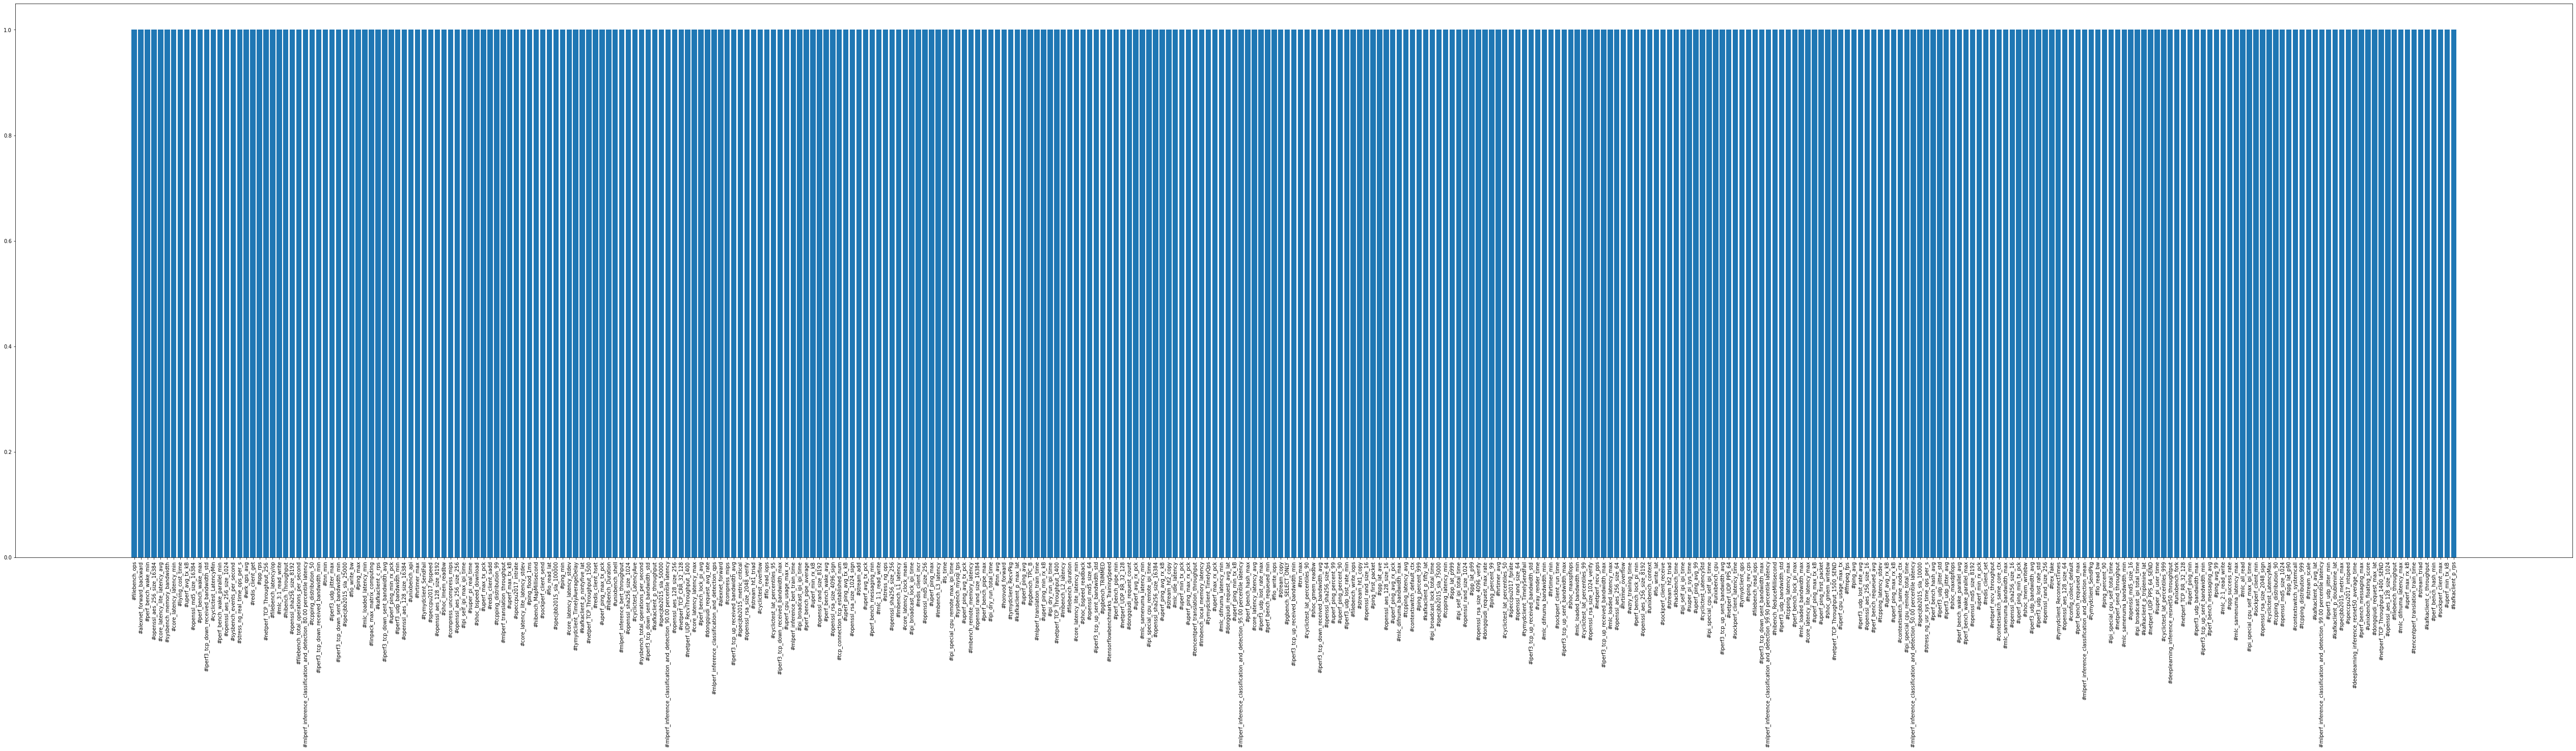

In [82]:
# 画图
plt.figure(figsize=(90, 20))
plt.bar(range(len(keyNumList)), keyNumList)
plt.xticks(range(len(keyNumList)), resultArgList, rotation=90)
plt.show()

In [26]:
def getMostImportantKey(resultArgList, keyNumList, threshold):
    # 获取重要的key
    importantKeyList = []
    for i in range(len(keyNumList)):
        if keyNumList[i] > threshold:
            importantKeyList.append(resultArgList[i])
    return importantKeyList

In [27]:
importantKeyList = getMostImportantKey(resultArgList, keyNumList, max(treshold))

In [28]:
def getImportantKeyDict(resultArgList,keyNumList,importantKeyList):
    # 获取重要key的字典
    importantKeyDict = {}
    for i in range(len(importantKeyList)):
        importantKeyDict[importantKeyList[i]] = keyNumList[resultArgList.index(importantKeyList[i])]
    return importantKeyDict

def showDict(yourDict):
    # 展示字典
    for key in yourDict:
        print(key, ':', yourDict[key])

In [29]:
importantKeyDict=getImportantKeyDict(resultArgList,keyNumList,importantKeyList)

In [30]:
showDict(importantKeyDict)

#super_pi_real_time : 2776
#ls_time : 4553
#stream_copy : 8858
#super_pi_sys_time : 2776
#super_pi_user_time : 2776
#stream_triad : 8858


In [31]:
def getValueByKey(keyTestT, key):
    valueList=[]
    keyTestT = keyTestT.reset_index(drop=True)
    for i in tqdm.tqdm(range(len(keyTestT))):
        results = json.loads(keyTestT.loc[i, 'results'])
        for result in results:
            if key in result:
                valueList.append(results[key])
                break
    return valueList

In [32]:
# 获得每一个重要key的值
def getAllValues(keyTestT, importantKeyList):
    valuesDict = {}
    for key in importantKeyList:
        valuesDict[key] = getValueByKey(keyTestT, key)
    return valuesDict

In [33]:
valuesDict = getAllValues(keyTestT, importantKeyList)

100%|██████████| 49505/49505 [00:02<00:00, 17539.30it/s]


In [34]:
showDict(valuesDict)

#super_pi_real_time : [19.947, 20.002, 19.98, 19.953, 14.88, 20.141, 20.03, 20.148, 19.887, 19.9, 19.832, 19.997, 19.958, 19.934, 19.998, 19.999, 20.259, 20.043, 14.878, 19.957, 20.102, 14.863, 19.968, 19.906, 19.988, 20.421, 19.99, 19.871, 19.838, 19.904, 20.017, 20.075, 20.158, 19.91, 19.947, 20.143, 20.146, 20.052, 20.247, 19.921, 19.928, 20.063, 20.153, 15.915, 20.159, 15.921, 18.359, 19.933, 14.859, 20.135, 20.143, 20.23, 20.002, 14.842, 19.856, 19.931, 20.036, 19.945, 14.865, 20.131, 20.236, 20.09, 19.952, 19.903, 20.031, 19.8, 20.169, 20.045, 19.877, 20.208, 19.868, 19.888, 14.898, 20.007, 20.053, 20.028, 14.922, 19.963, 19.965, 19.981, 19.857, 19.943, 20.326, 19.991, 20.03, 20.01, 20.015, 20.053, 20.255, 20.052, 19.896, 20.295, 20.322, 19.938, 19.985, 19.833, 19.19, 14.907, 14.875, 20.009, 19.961, 19.928, 19.963, 20.048, 20.311, 20.138, 19.847, 19.977, 19.852, 14.873, 19.989, 20.208, 19.968, 19.809, 20.032, 20.113, 19.984, 20.098, 19.865, 19.917, 20.213, 20.027, 20.098, 14.849,

In [35]:
# 将valuesDict中的#stream_copy，#stream_triad提取出来，组成DataFrame
streamCopyTriad = pd.DataFrame()
streamCopyTriad['stream_copy'] = valuesDict['#stream_copy']
streamCopyTriad['stream_triad'] = valuesDict['#stream_triad']
streamCopyTriad.shape

(8858, 2)

In [36]:
streamCopyTriad.head()

stream_copy  stream_triad
0      6125.00       8624.97
1      6233.37       8502.60
2     40942.27      33983.97
3    131557.03     146433.63
4     13864.97       8612.30

In [57]:
def getInput(keyTestT, importantKeyList):
    # 根据result中是否有importantKeyList[1]和importantKeyList[3]来提取dimension输入
    inputList = []
    keys_to_extract = ['cvm_cpu', 'cvm_memory', 'cvm_cpu_qos', 'cvm_os_type']
    for i in tqdm.tqdm(range(len(keyTestT))):
        results = json.loads(keyTestT.loc[i, 'results'])
        has_key1 = False
        has_key2 = False
        for result in results:
            if importantKeyList[2] in result:
                has_key1 = True
            if importantKeyList[5] in result:
                has_key2 = True
            if has_key1 == True and has_key2 == True:
                # 将dimension中['cvm_cpu', 'cvm_memory', 'cvm_cpu_qos', 'cvm_os_type']这几个字段的值提取出来
                dimension = json.loads(keyTestT.loc[i, 'dimension'])
                dimension = json.dumps(dimension)
                templist=['cvm_cpu', 'cvm_memory', 'cvm_cpu_qos', 'cvm_os_type']
                dimensionJson = json.loads(dimension)
                for key in dimensionJson:
                    if key in templist:
                        key_value = dimensionJson[key]
                        if key=='cvm_memory':
                            key_value=float(key_value.split(' ')[0])
                        elif key=='cvm_cpu':
                            key_value=float(key_value)
                        elif key=='cvm_cpu_qos':
                            key_value='true'
                        templist[keys_to_extract.index(key)]=key_value
                inputList.append(templist)
                break
    return inputList

In [58]:
inputList = getInput(keyTestT, importantKeyList)

100%|██████████| 49505/49505 [00:06<00:00, 7374.55it/s]


In [59]:
print(len(inputList))
# 打印前5个
for i in range(5):
    print(inputList[i])

8858
[2.0, 8.0, 'cvm_cpu_qos', 'CentOS Linux release 8.2.2004 (Core)']
[80.0, 192.0, 'cvm_cpu_qos', 'CentOS Linux release 7.6.1810 (Core)']
[80.0, 192.0, 'cvm_cpu_qos', 'CentOS Linux release 7.6.1810 (Core)']
[80.0, 192.0, 'cvm_cpu_qos', 'CentOS Linux release 7.6.1810 (Core)']
[80.0, 192.0, 'cvm_cpu_qos', 'CentOS Linux release 7.6.1810 (Core)']


In [60]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [61]:
def showPic(methodName, y_test, y_pred):
    # 创建柱状图
    plt.figure(figsize=(80, 15))

    plt.subplot(1, 3, 1)
    plt.scatter(y_test, y_pred)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('{}: True Values vs. Predicted Values'.format(methodName))

    plt.subplot(1, 3, 2)
    # 创建样本索引数组
    index = np.arange(len(y_test))
    # 绘制线性回归模型的折线图
    plt.plot(index, y_test, label='True Values')
    plt.plot(index, y_pred, label='Predicted Values')
    plt.xlabel('Sample Index')
    plt.ylabel('Values')
    plt.title('{}: True Values vs. Predicted Values'.format(methodName))
    plt.legend()

    plt.subplot(1, 3, 3)
    # 计算残差
    residuals = y_test - y_pred
    # 绘制线性回归模型的残差图
    plt.scatter(y_test, residuals)
    plt.xlabel('True Values')
    plt.ylabel('Residuals')
    plt.title('{}: True Values vs. Residuals'.format(methodName))
    plt.axhline(0, color='red', linestyle='--')

    plt.show()



def train(X, y):
    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    # 初始化模型
    linear_reg = LinearRegression()
    decision_tree_reg = DecisionTreeRegressor()
    random_forest_reg = RandomForestRegressor()
    svm_reg = SVR()
    knn_reg = KNeighborsRegressor()


    # 拟合模型
    linear_reg.fit(X_train, y_train)
    decision_tree_reg.fit(X_train, y_train)
    random_forest_reg.fit(X_train, y_train)
    svm_reg.fit(X_train, y_train)
    knn_reg.fit(X_train, y_train)


    # 预测
    y_pred_linear_reg = linear_reg.predict(X_test)
    y_pred_decision_tree_reg = decision_tree_reg.predict(X_test)
    y_pred_random_forest_reg = random_forest_reg.predict(X_test)
    y_pred_svm_reg = svm_reg.predict(X_test)
    y_pred_knn_reg = knn_reg.predict(X_test)


    # 计算评估指标
    mse_linear_reg = mean_squared_error(y_test, y_pred_linear_reg)
    mse_decision_tree_reg = mean_squared_error(y_test, y_pred_decision_tree_reg)
    mse_random_forest_reg = mean_squared_error(y_test, y_pred_random_forest_reg)
    mse_svm_reg = mean_squared_error(y_test, y_pred_svm_reg)
    mse_knn_reg = mean_squared_error(y_test, y_pred_knn_reg)

    mae_linear_reg = mean_absolute_error(y_test, y_pred_linear_reg)
    mae_decision_tree_reg = mean_absolute_error(y_test, y_pred_decision_tree_reg)
    mae_random_forest_reg = mean_absolute_error(y_test, y_pred_random_forest_reg)
    mae_svm_reg = mean_absolute_error(y_test, y_pred_svm_reg)
    mae_knn_reg = mean_absolute_error(y_test, y_pred_knn_reg)

    r2_linear_reg = r2_score(y_test, y_pred_linear_reg)
    r2_decision_tree_reg = r2_score(y_test, y_pred_decision_tree_reg)
    r2_random_forest_reg = r2_score(y_test, y_pred_random_forest_reg)
    r2_svm_reg = r2_score(y_test, y_pred_svm_reg)
    r2_knn_reg = r2_score(y_test, y_pred_knn_reg)


    # 打印评估指标
    # print('Linear Regression MSE:', mse_linear_reg)
    # print('Decision Tree Regression MSE:', mse_decision_tree_reg)
    # print('Random Forest Regression MSE:', mse_random_forest_reg)
    # print('Support Vector Regression MSE:', mse_svm_reg)
    # print('KNN Regression MSE:', mse_knn_reg)
    # print('\n')
    # print('Linear Regression MAE:', mae_linear_reg)
    # print('Decision Tree Regression MAE:', mae_decision_tree_reg)
    # print('Random Forest Regression MAE:', mae_random_forest_reg)
    # print('Support Vector Regression MAE:', mae_svm_reg)
    # print('KNN Regression MAE:', mae_knn_reg)
    # print('\n')
    print('Linear Regression R2:', r2_linear_reg)
    print('Decision Tree Regression R2:', r2_decision_tree_reg)
    print('Random Forest Regression R2:', r2_random_forest_reg)
    print('Support Vector Regression R2:', r2_svm_reg)
    print('KNN Regression R2:', r2_knn_reg)
    print('\n')

    models = ['Linear Regression', 'Decision Tree Regression', 'Random Forest Regression', 'SVM Regression', 'KNN Regression']
    y_pred = ['y_pred_linear_reg', 'y_pred_decision_tree_reg', 'y_pred_random_forest_reg', 'y_pred_svm_reg', 'y_pred_knn_reg']
    for i in range(len(models)):
        showPic(models[i], y_test, eval(y_pred[i]))


In [73]:
df = pd.DataFrame(inputList, columns=['cvm_cpu', 'cvm_memory', 'cvm_cpu_qos', 'cvm_os_type'])
# 判断['cvm_cpu', 'cvm_memory']这两列的值是否是数字，若不是数字则替换为0
df[['cvm_cpu', 'cvm_memory']] = df[['cvm_cpu', 'cvm_memory']].apply(pd.to_numeric, errors='coerce').fillna(0)

Linear Regression MSE: 760195000.4022983
Decision Tree Regression MSE: 808156786.9302777
Random Forest Regression MSE: 802880044.753009
Support Vector Regression MSE: 1206123401.5916238
KNN Regression MSE: 976924976.1137431


Linear Regression MAE: 14622.337124647678
Decision Tree Regression MAE: 15022.0834290122
Random Forest Regression MAE: 15010.71747642515
Support Vector Regression MAE: 14907.555712596935
KNN Regression MAE: 16382.578473664411


Linear Regression R2: 0.2690441712082634
Decision Tree Regression R2: 0.22292712570896556
Random Forest Regression R2: 0.22800091000044953
Support Vector Regression R2: -0.15973260830307412
KNN Regression R2: 0.060650221055558506




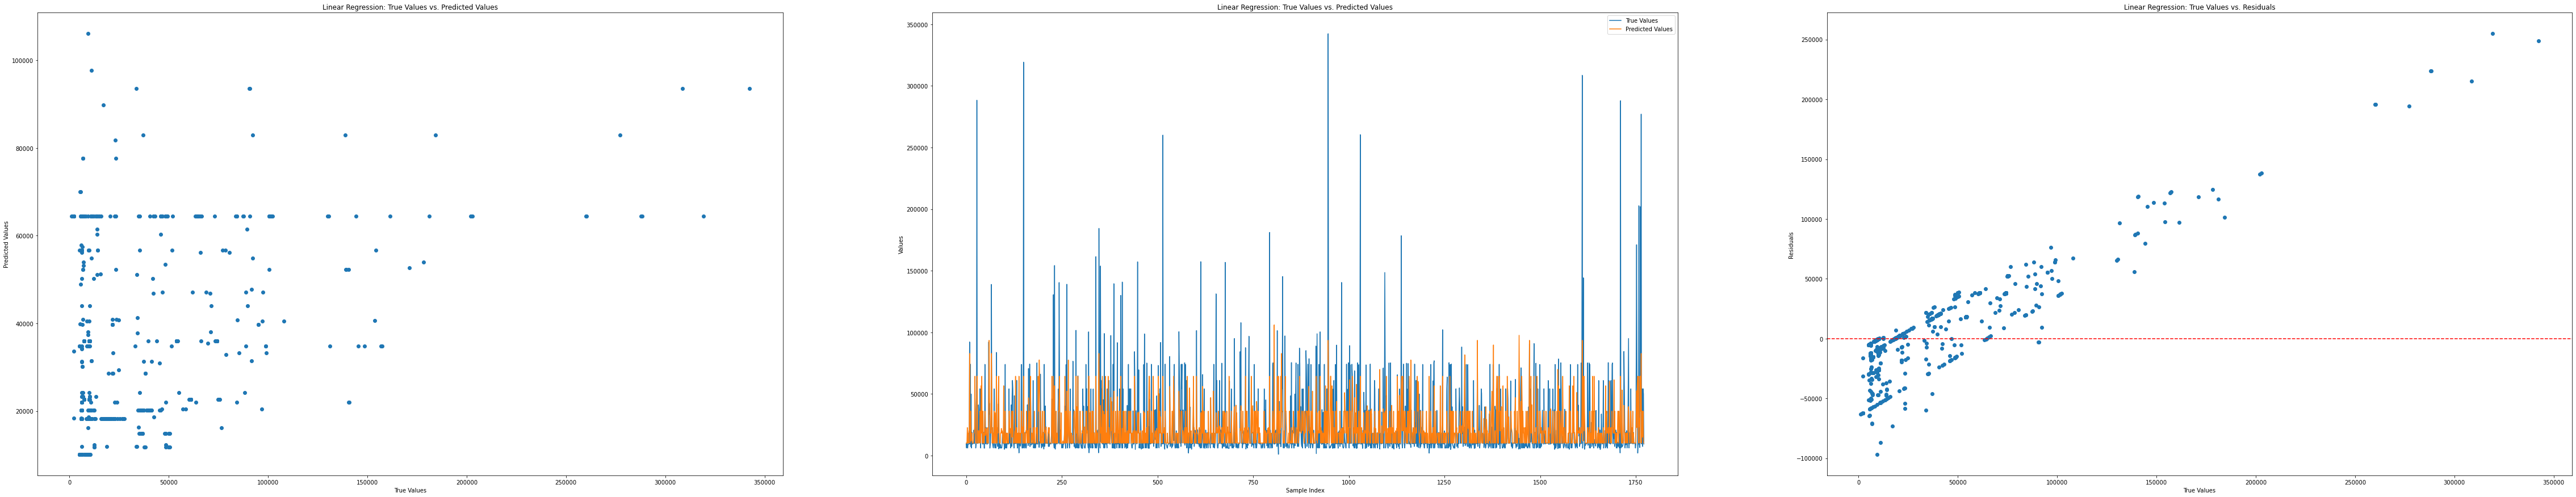

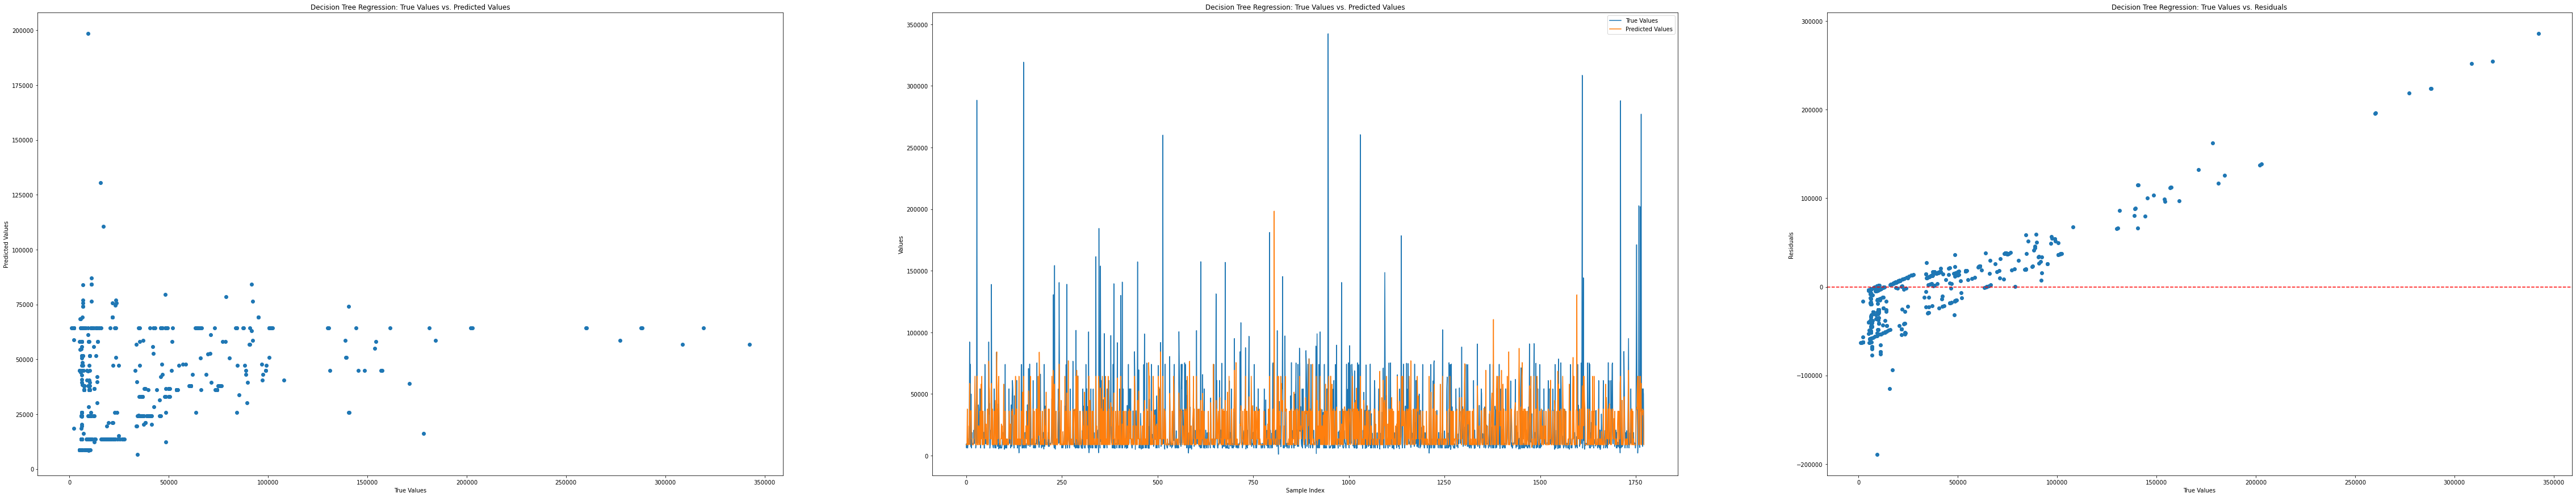

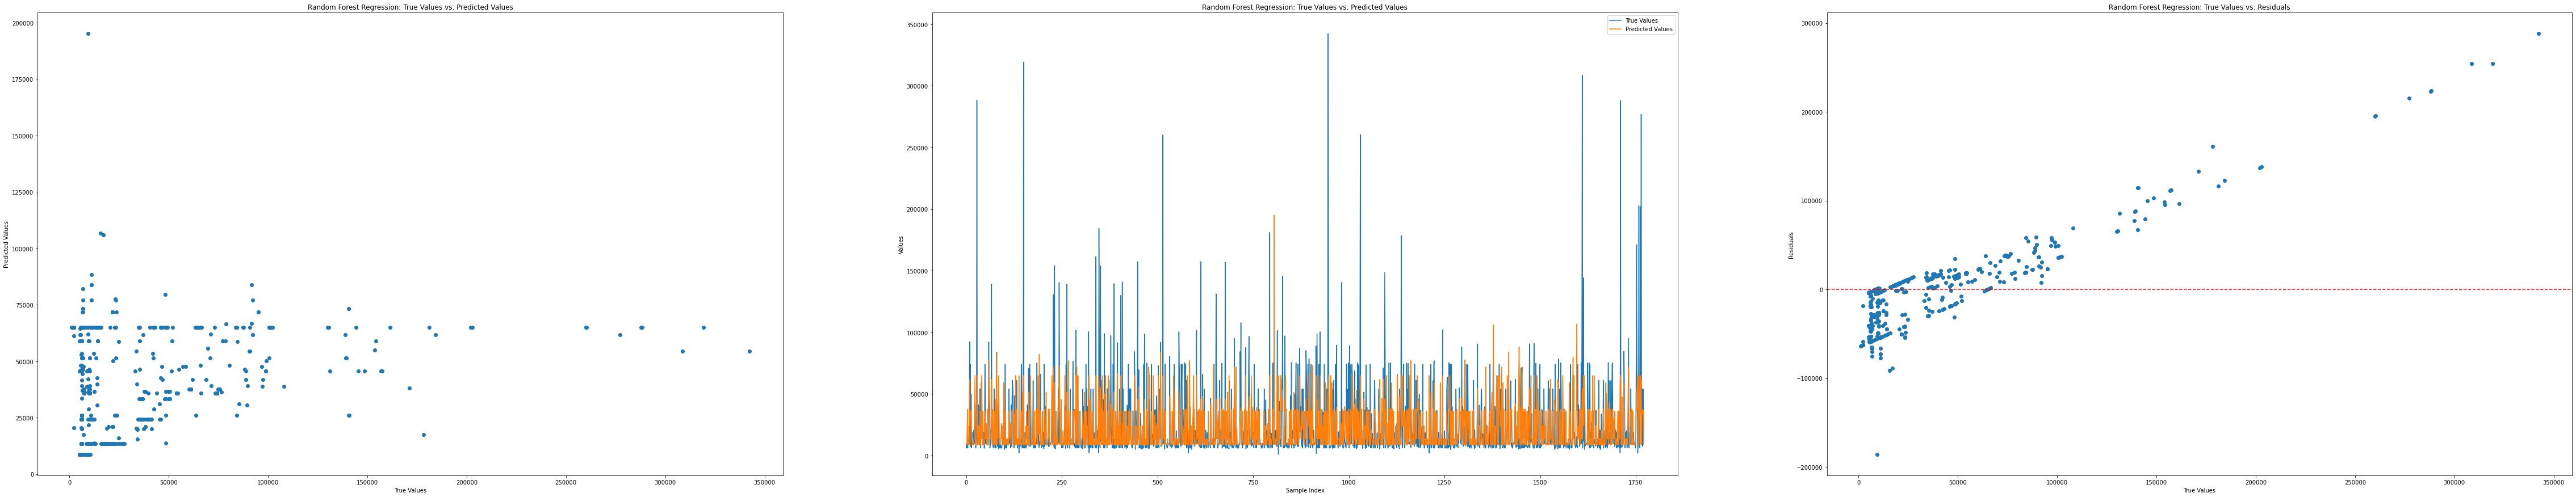

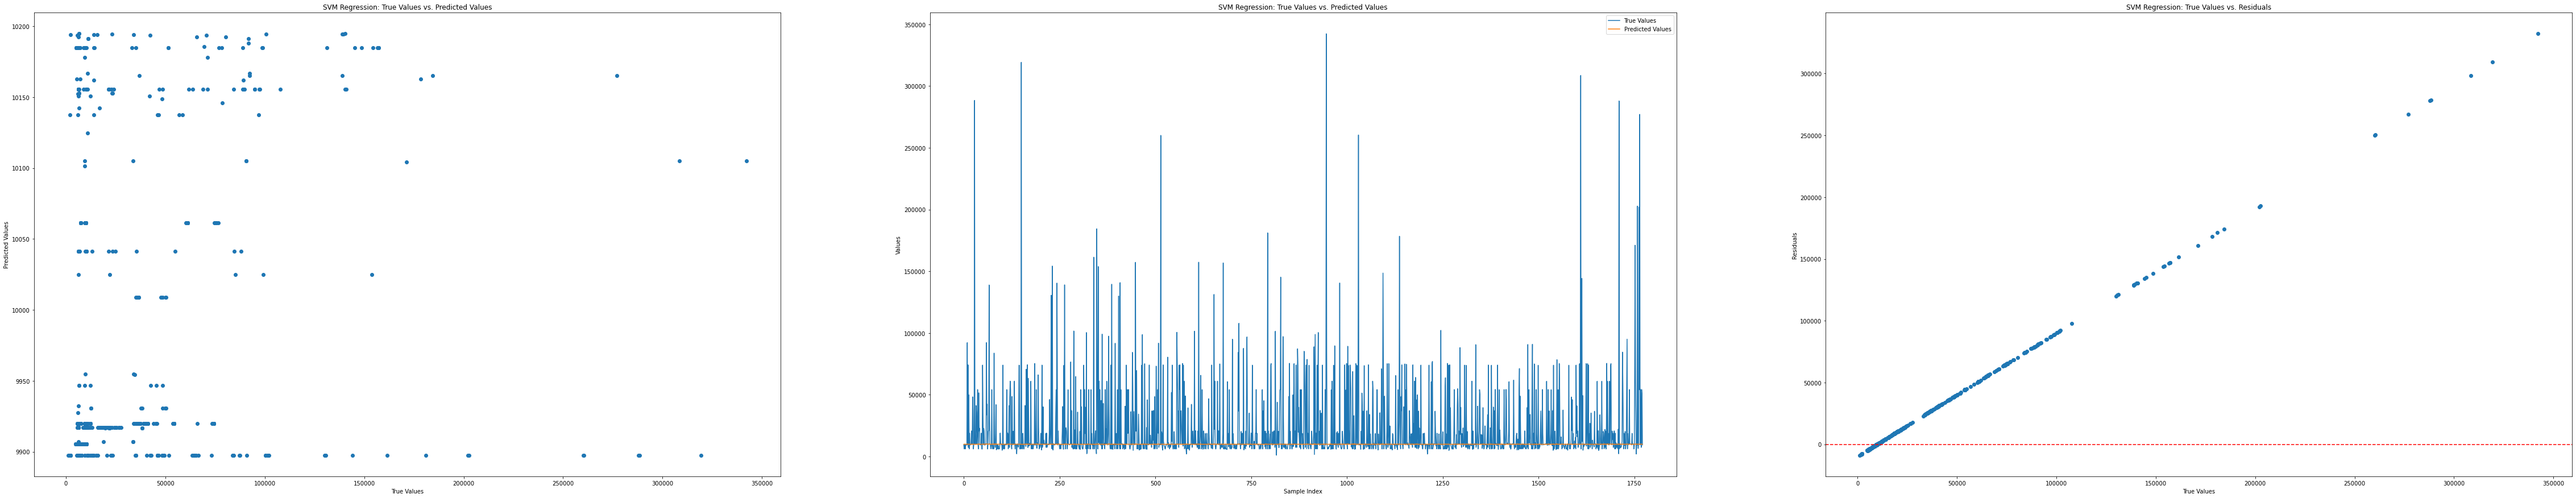

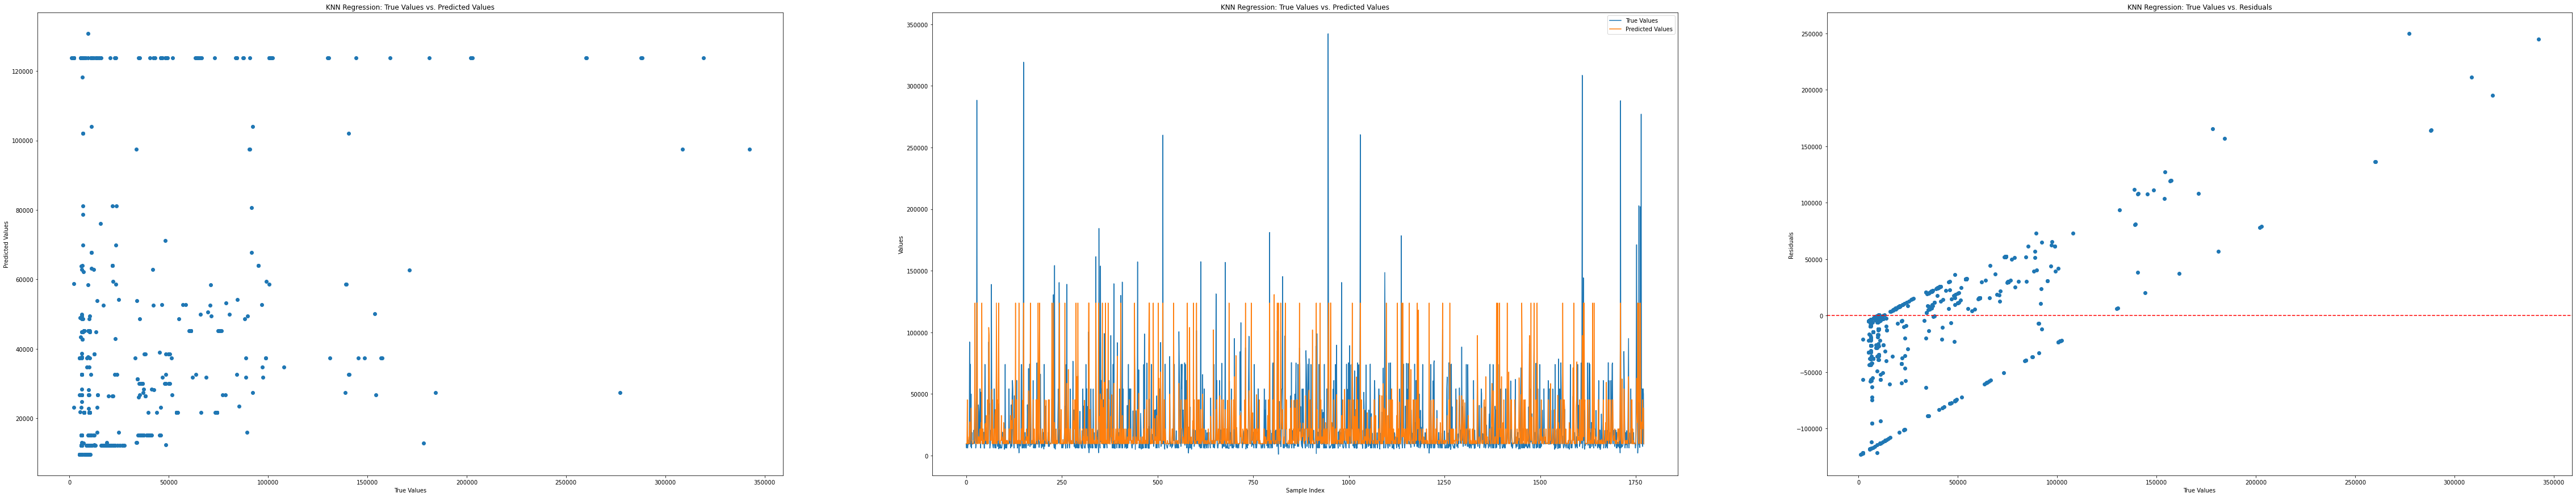

In [74]:
df['cvm_cpu'] = pd.to_numeric(df['cvm_cpu'])
df['cvm_memory'] = pd.to_numeric(df['cvm_memory'])
one_hot_df = pd.get_dummies(df, columns=['cvm_cpu_qos', 'cvm_os_type'])
X = one_hot_df
y = streamCopyTriad['stream_copy']
train(X, y)

(8858, 100)
Linear Regression MSE: 1.1838871578400801e+27
Decision Tree Regression MSE: 808554851.7005609
Random Forest Regression MSE: 798653808.9738506
Support Vector Regression MSE: 1198460572.2573693
KNN Regression MSE: 829427512.0008711


Linear Regression MAE: 817378676747.5173
Decision Tree Regression MAE: 15025.992885386473
Random Forest Regression MAE: 14997.034049804523
Support Vector Regression MAE: 14872.542190543016
KNN Regression MAE: 15590.141126787059


Linear Regression R2: -1.138351631090618e+18
Decision Tree Regression R2: 0.22254437159466434
Random Forest Regression R2: 0.23206459323302686
Support Vector Regression R2: -0.15236451226989134
KNN Regression R2: 0.20247453069749




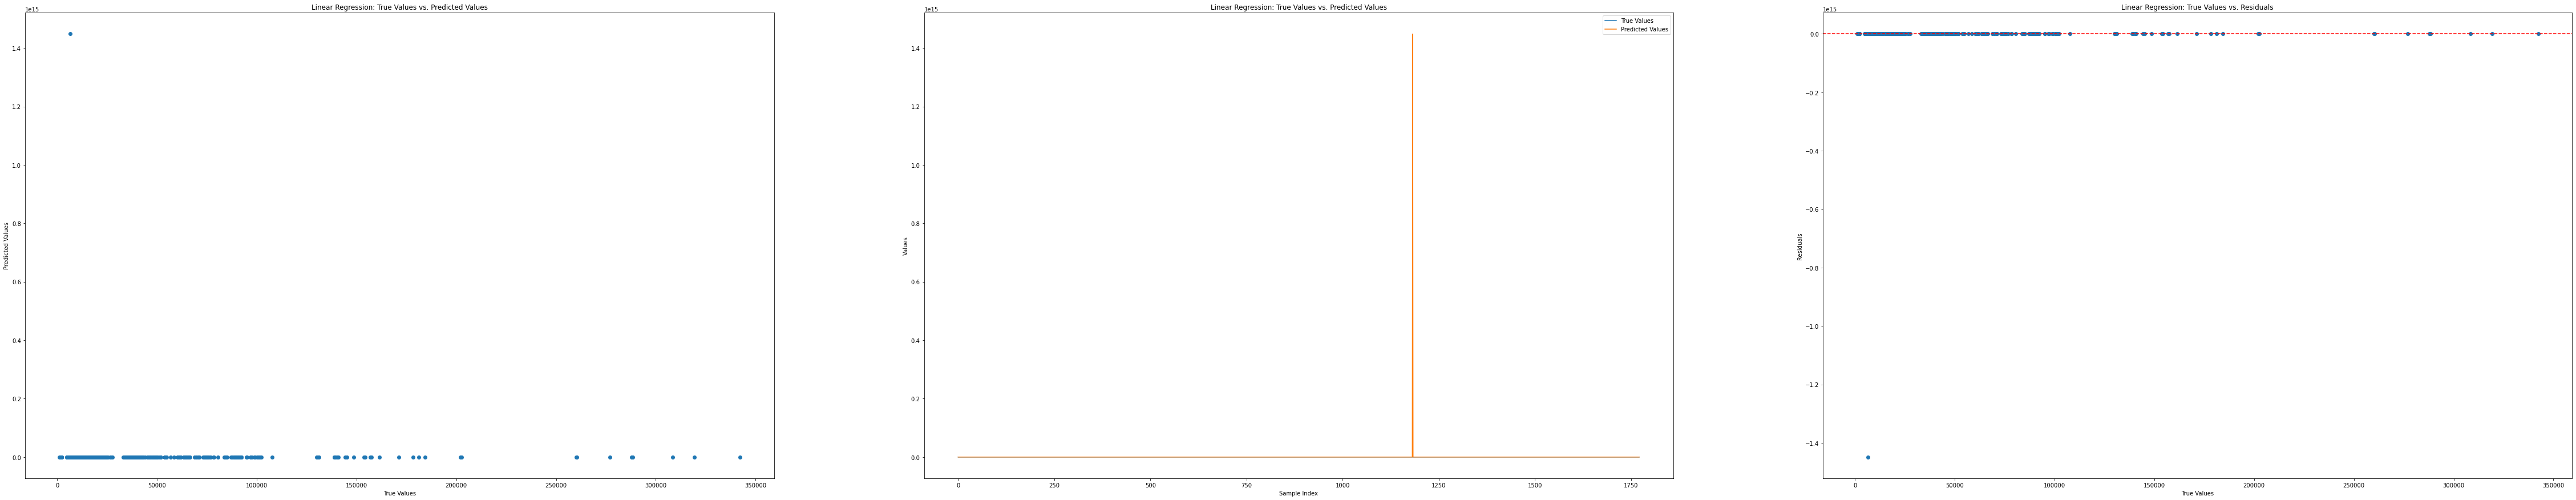

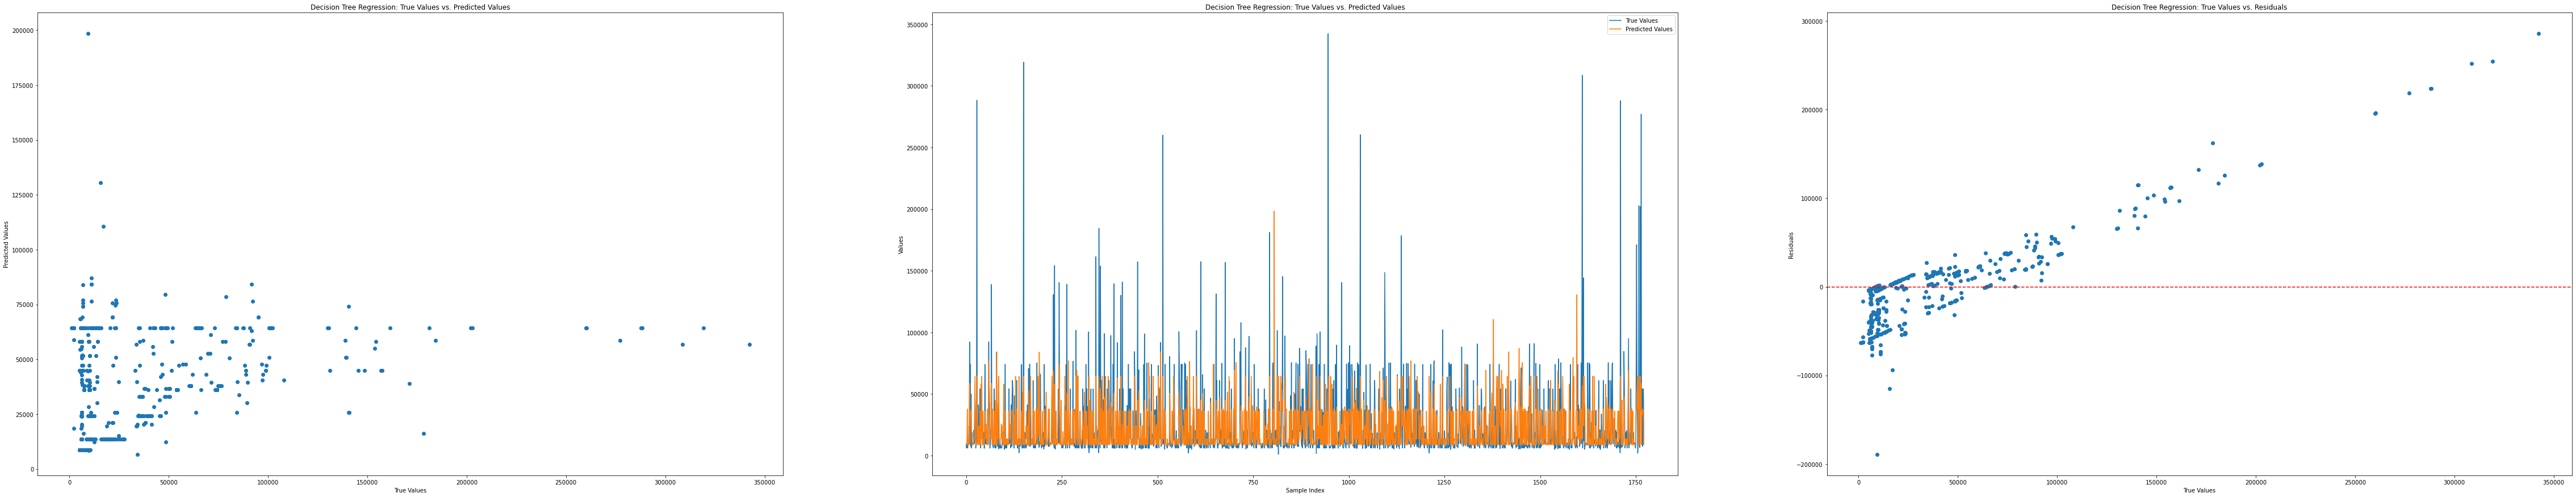

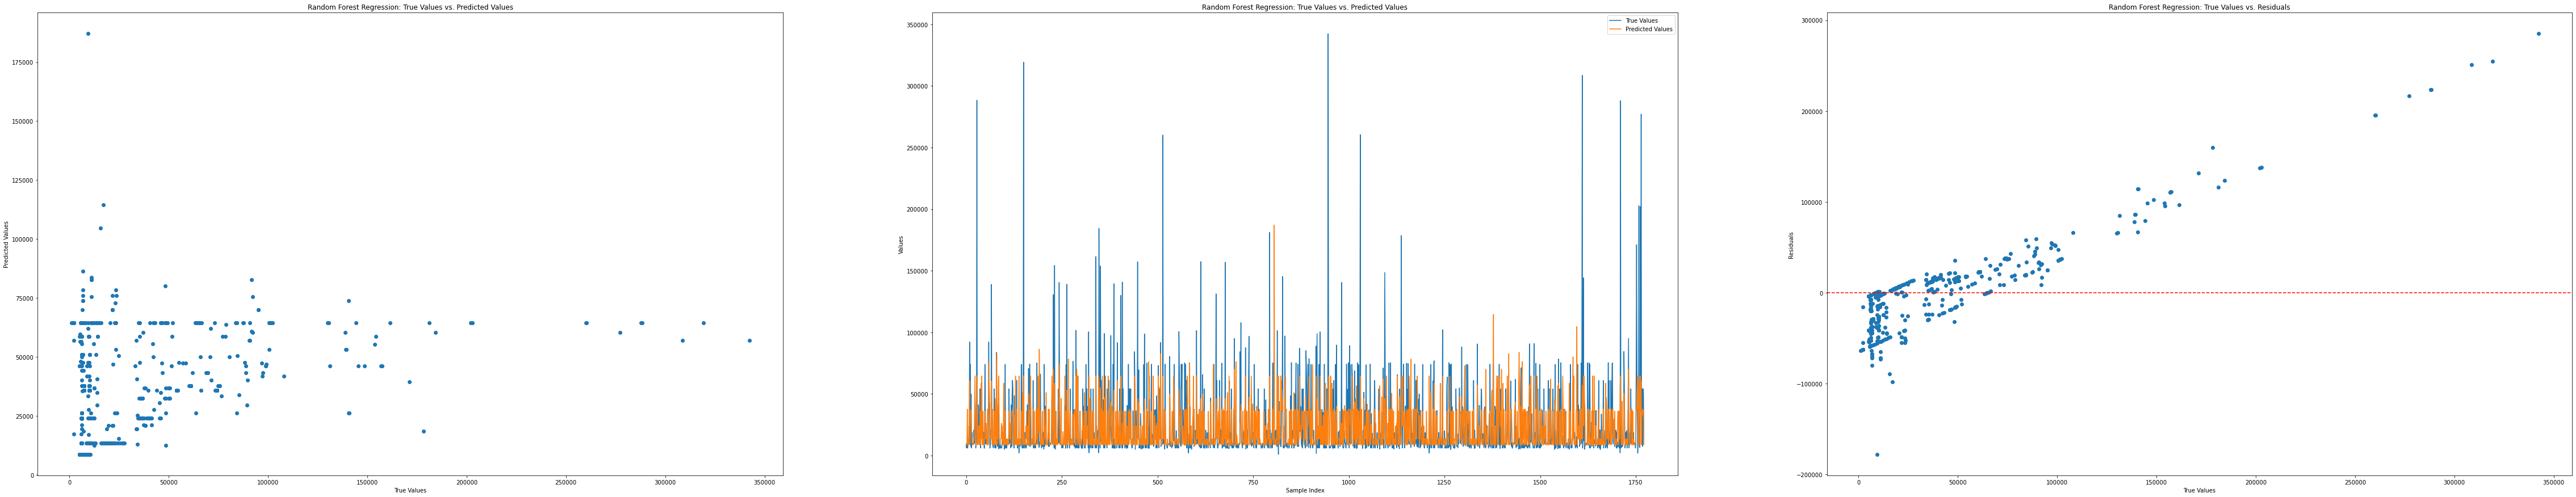

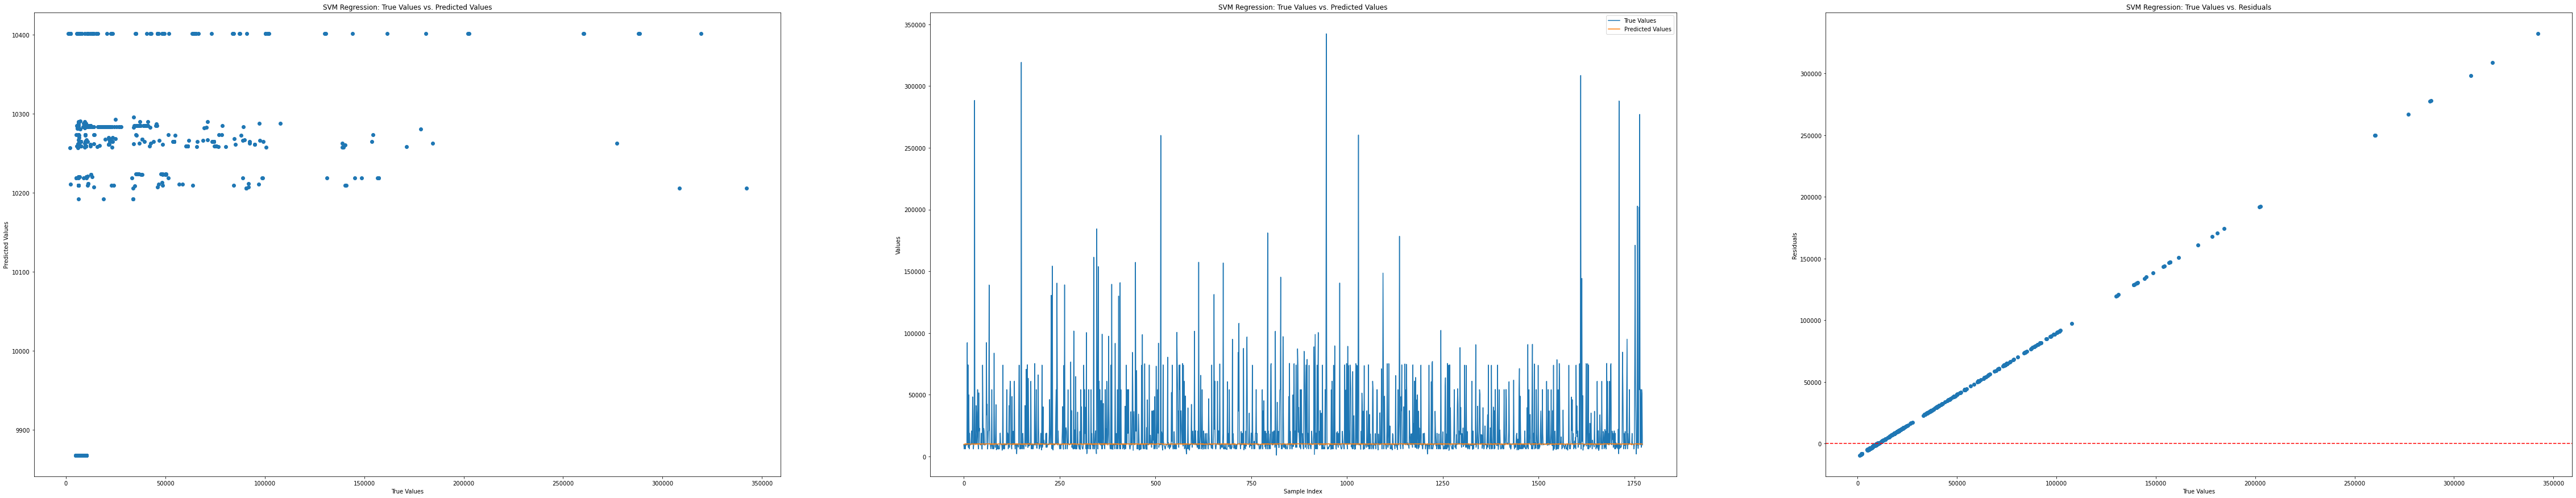

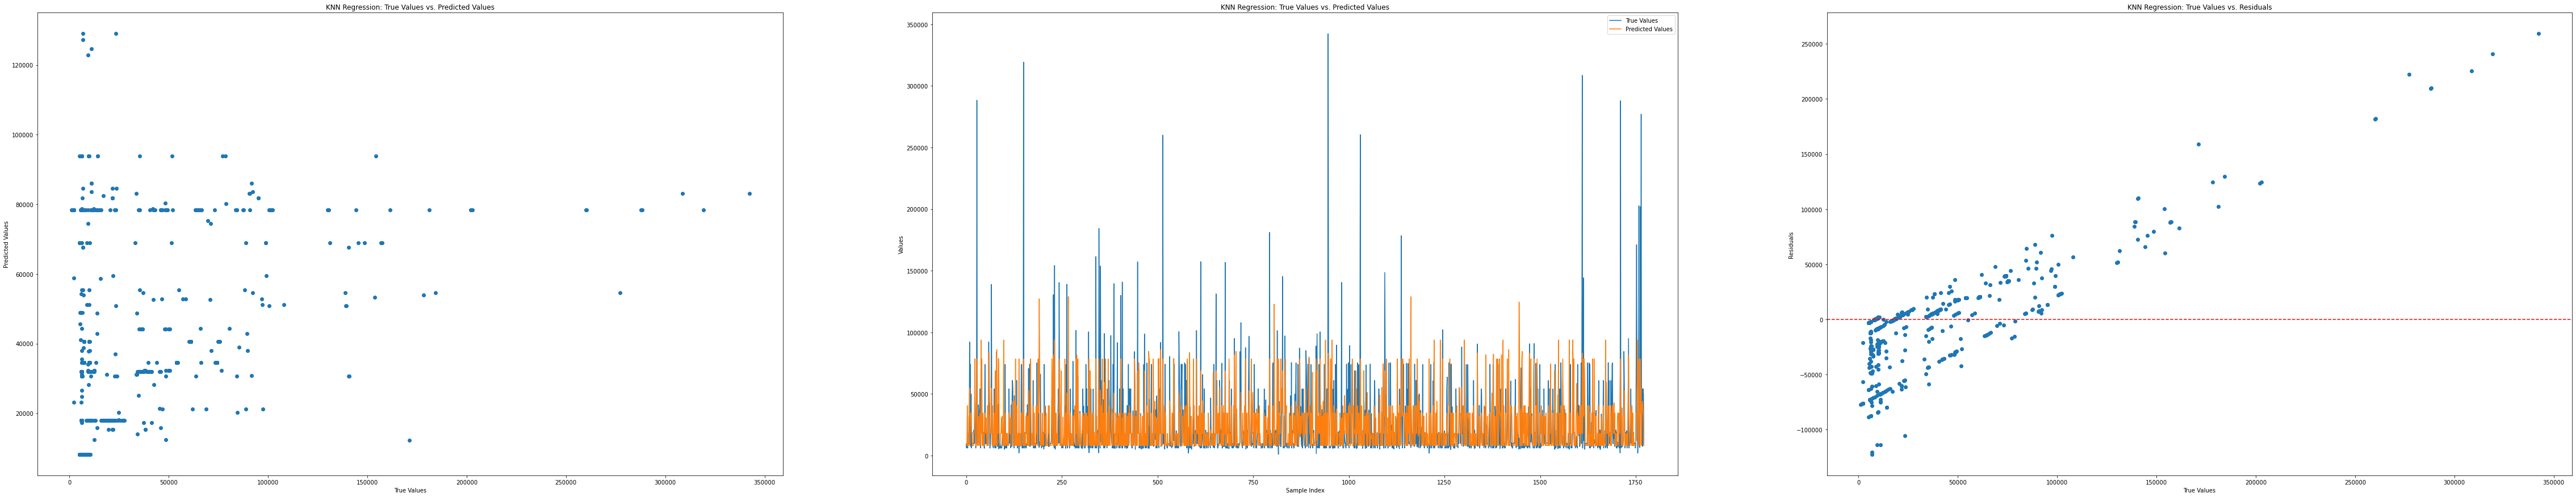

In [62]:
# # one-hot编码
# df = pd.DataFrame(inputList, columns=['cvm_cpu', 'cvm_memory', 'cvm_cpu_qos', 'cvm_os_type'])
# one_hot_df = pd.get_dummies(df)
# # print(one_hot_df)
# print(one_hot_df.shape)
# # 将one-hot编码后的数据和streamCopyTriad合并
# # one_hot_data = pd.concat([one_hot_df, streamCopyTriad], axis=1)
# # print(one_hot_data.shape)

# X = one_hot_df
# y = streamCopyTriad['stream_copy']

# train(X, y)

(8858, 4)
Linear Regression MSE: 892603163.8102468
Decision Tree Regression MSE: 809572193.5685718
Random Forest Regression MSE: 799977646.045341
Support Vector Regression MSE: 1201255572.4961503
KNN Regression MSE: 1569958205.6631129


Linear Regression MAE: 16997.613684414093
Decision Tree Regression MAE: 15026.106424372118
Random Forest Regression MAE: 15009.830618481923
Support Vector Regression MAE: 14881.48792775921
KNN Regression MAE: 18717.29903085026


Linear Regression R2: 0.1417287866405802
Decision Tree Regression R2: 0.22156615946764058
Random Forest Regression R2: 0.23079167454339544
Support Vector Regression R2: -0.15505200918177575
KNN Regression R2: -0.5095733341860569




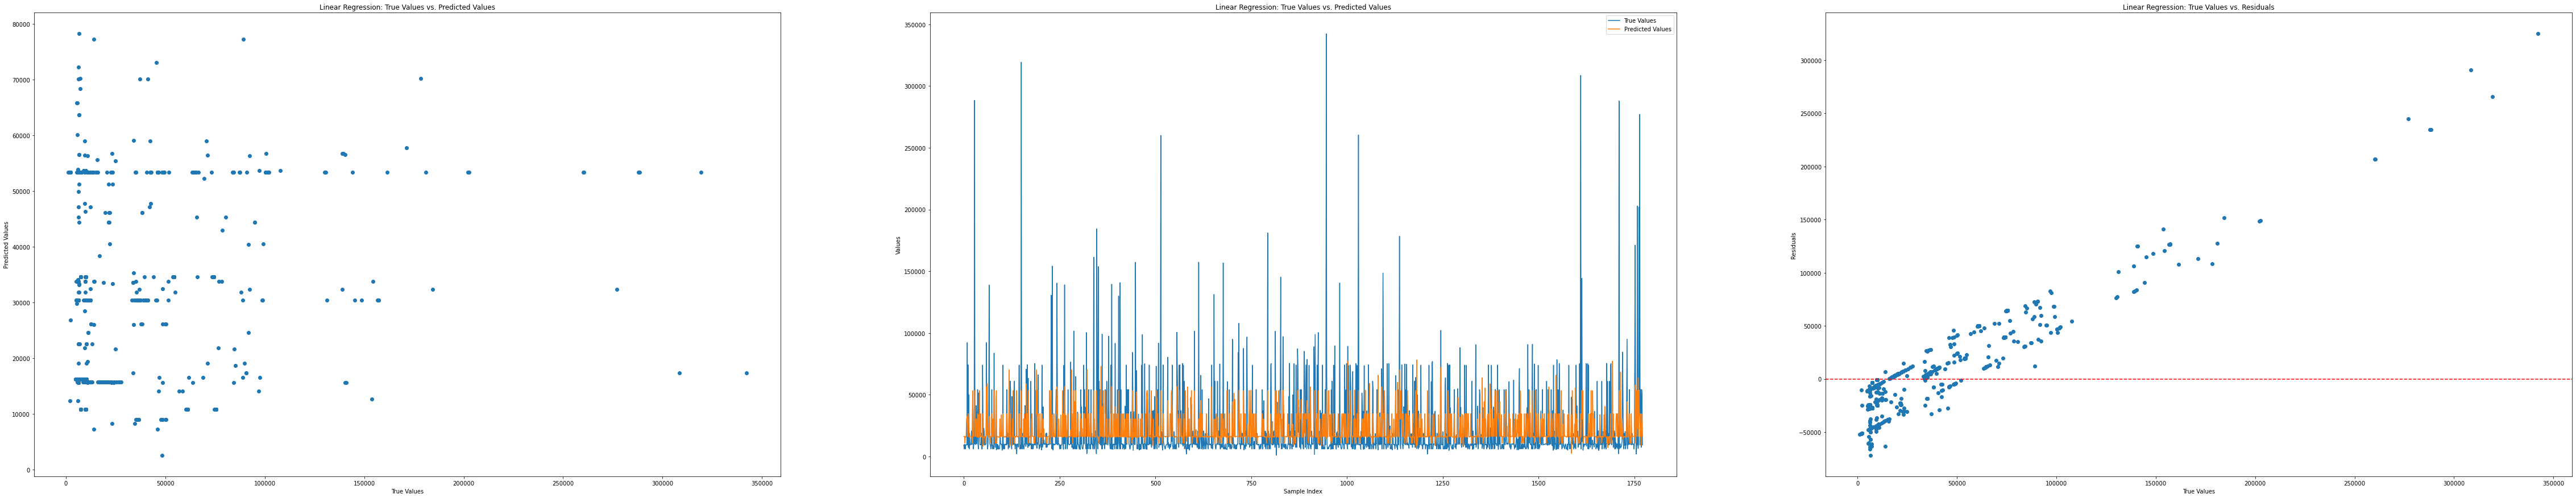

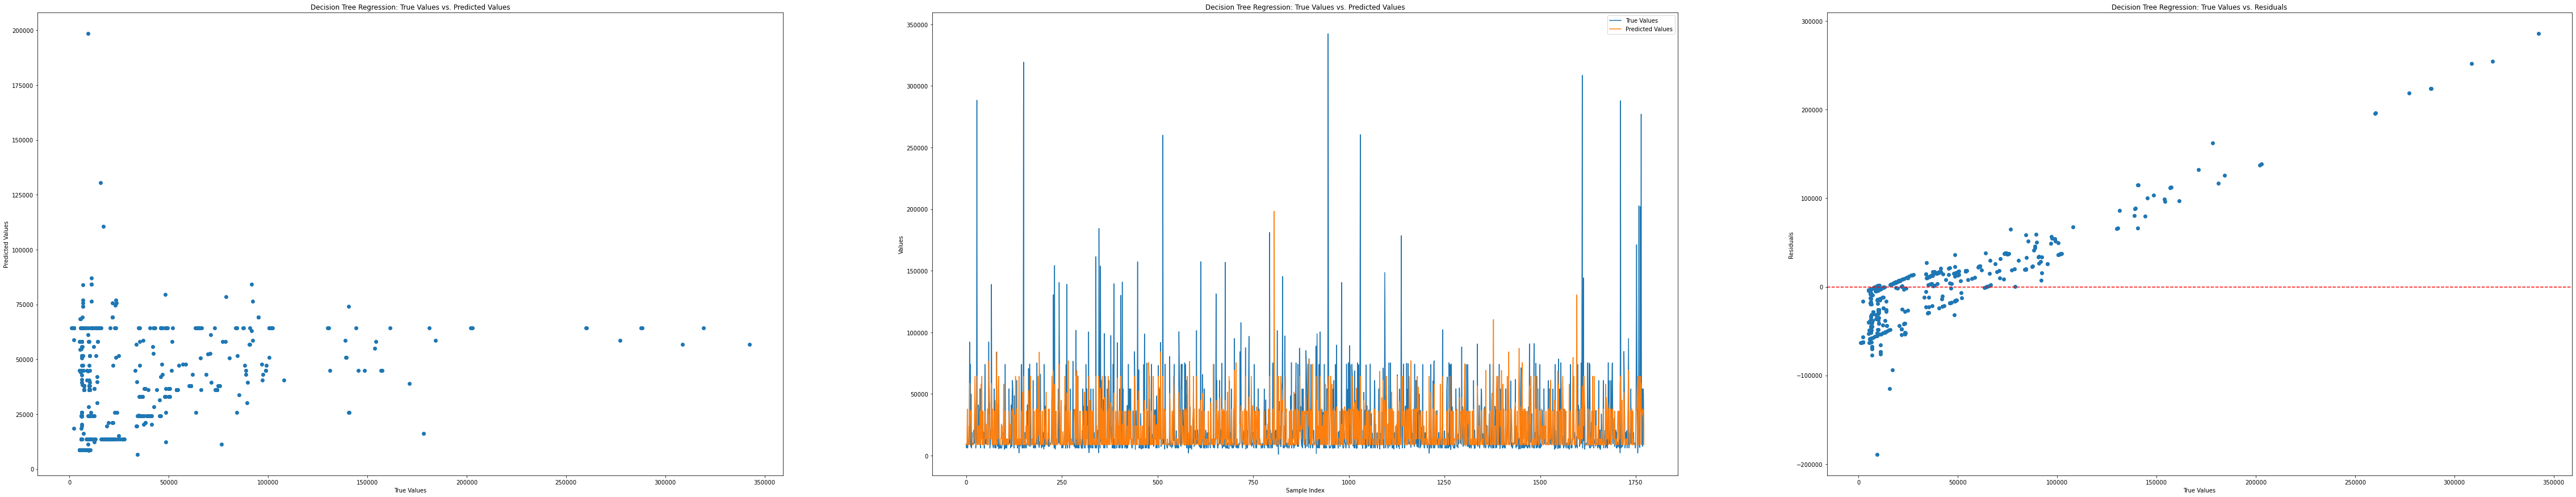

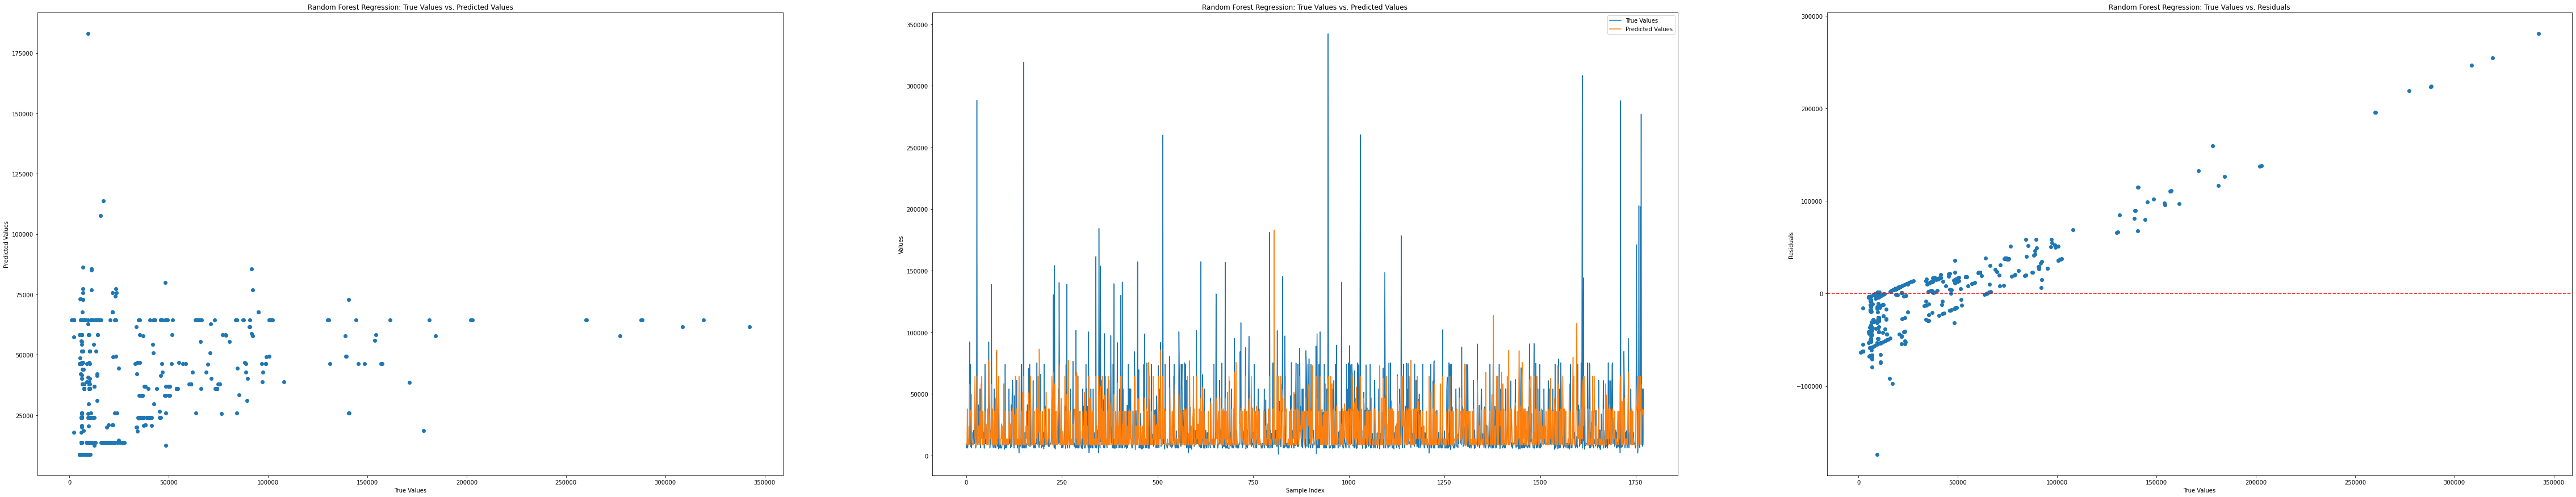

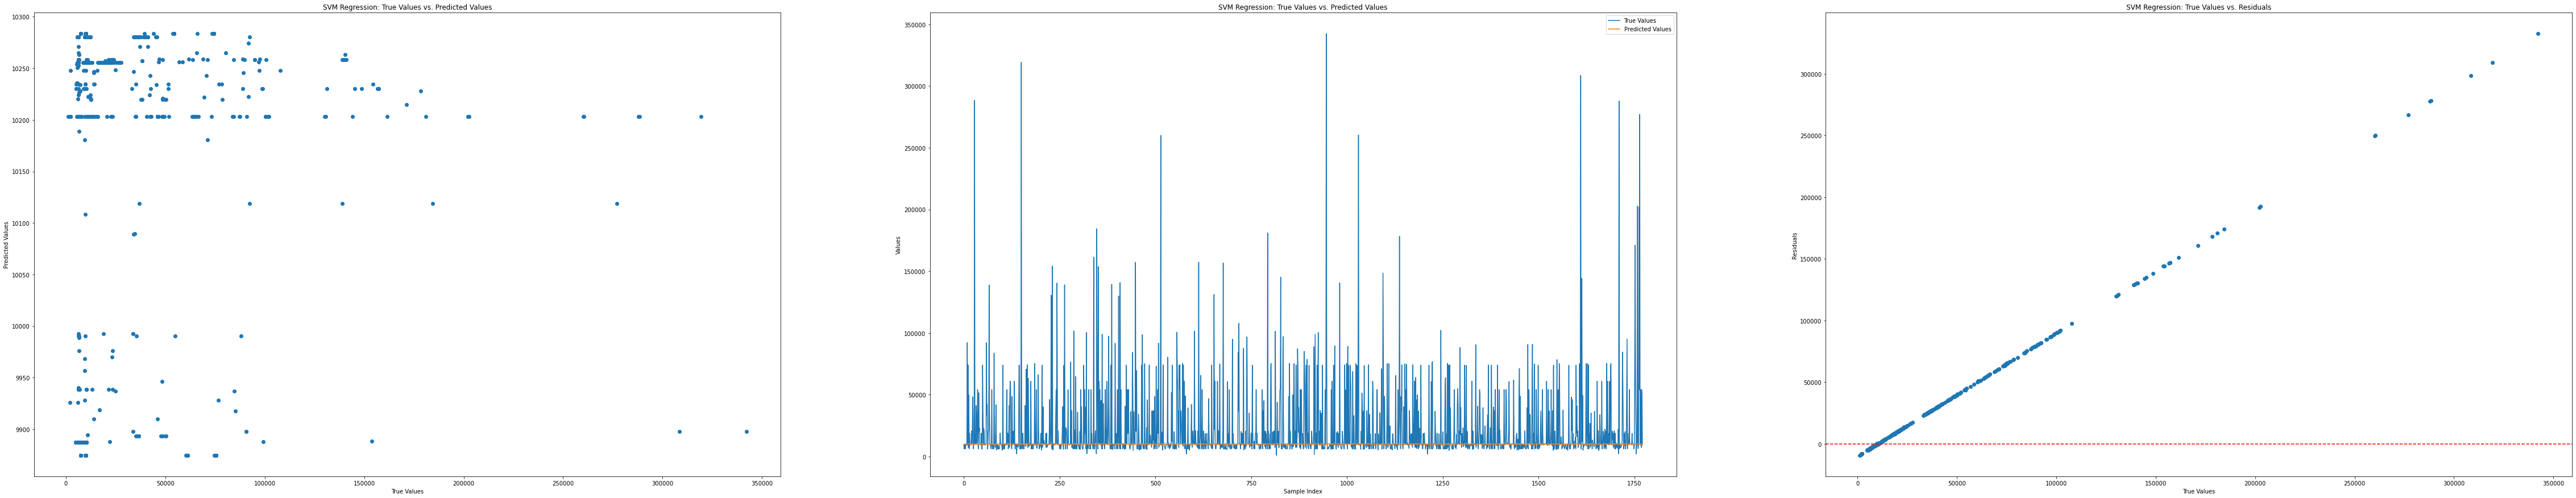

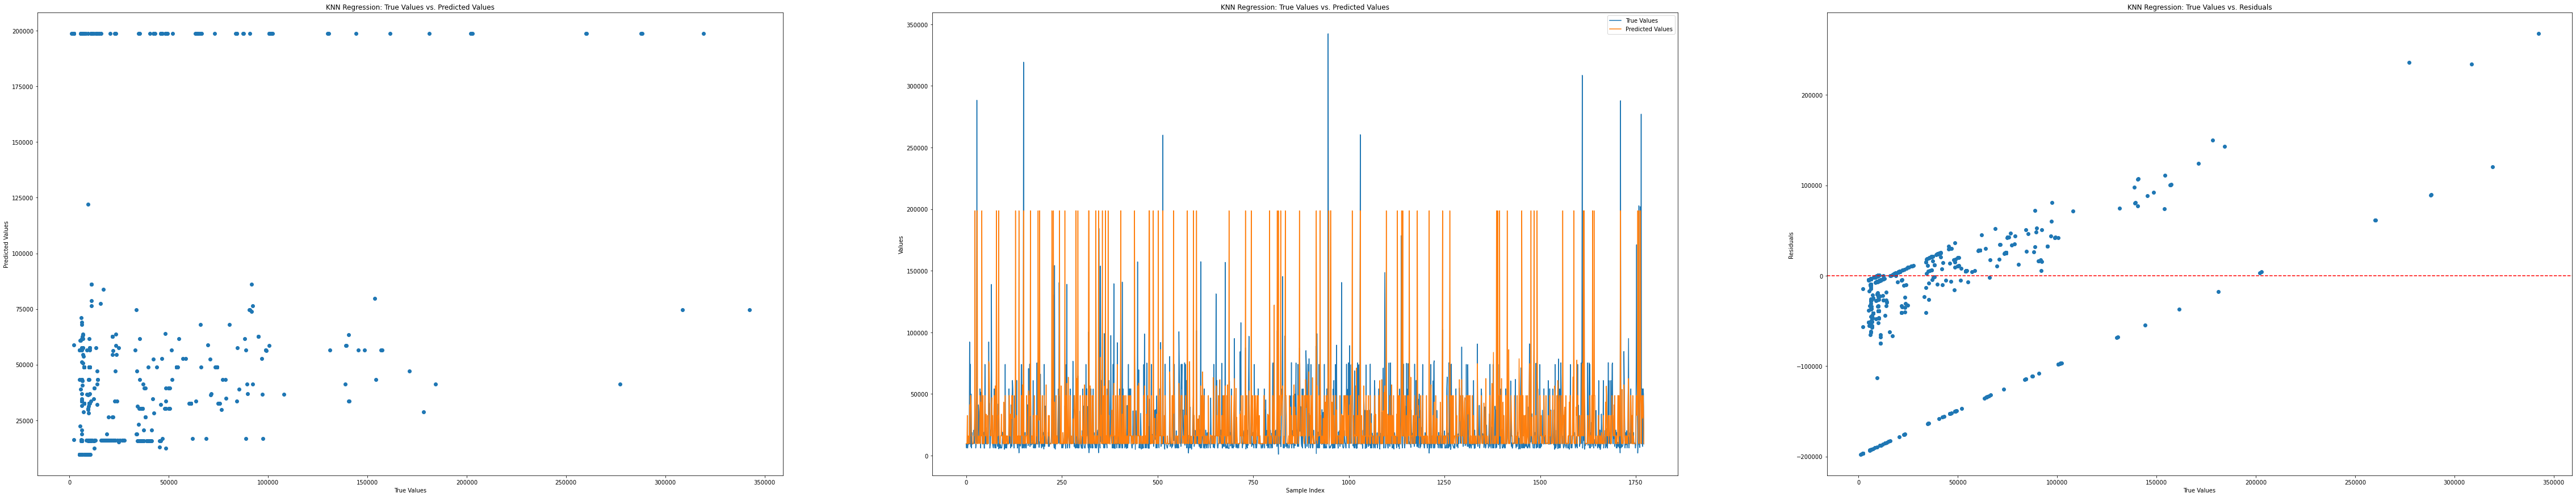

In [63]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['cvm_cpu_qos'] = encoder.fit_transform(df['cvm_cpu_qos'])
df['cvm_os_type'] = encoder.fit_transform(df['cvm_os_type'])
# 合并编码后的列与前两列
merged_label_df = df[['cvm_cpu', 'cvm_memory', 'cvm_cpu_qos', 'cvm_os_type']]
print(merged_label_df.shape)
dfL = df.astype(str)
merged_label_df = dfL.apply(encoder.fit_transform)
# 将label编码后的数据和streamCopyTriad合并
# label_data = pd.concat([merged_label_df, streamCopyTriad], axis=1)
# print(label_data.shape)
# label_data.head()

X = merged_label_df
y = streamCopyTriad['stream_copy']

# train(X, y)

(8858, 81)
Linear Regression MSE: 766009227.6587819
Decision Tree Regression MSE: 808837037.4545627
Random Forest Regression MSE: 803523702.3074224
Support Vector Regression MSE: 1206448809.5179188
KNN Regression MSE: 867652146.367704


Linear Regression MAE: 14911.507694112946
Decision Tree Regression MAE: 15029.667898491567
Random Forest Regression MAE: 15014.121427157543
Support Vector Regression MAE: 14903.85128727899
KNN Regression MAE: 15397.260139954855


Linear Regression R2: 0.2634535749786152
Decision Tree Regression R2: 0.22227303947385268
Random Forest Regression R2: 0.22738200926985364
Support Vector Regression R2: -0.1600455001536314
KNN Regression R2: 0.16572011994882252




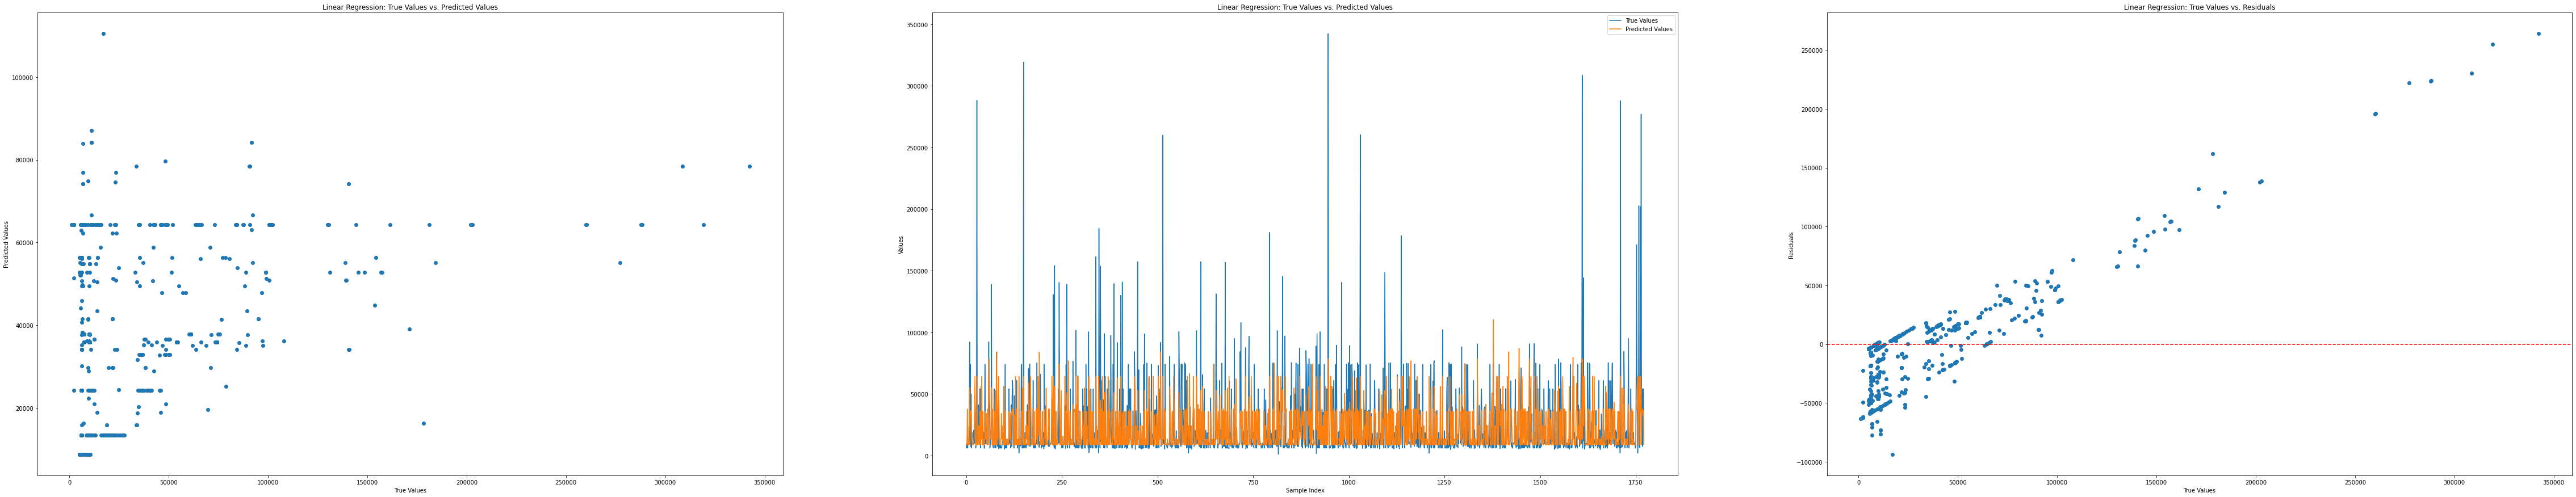

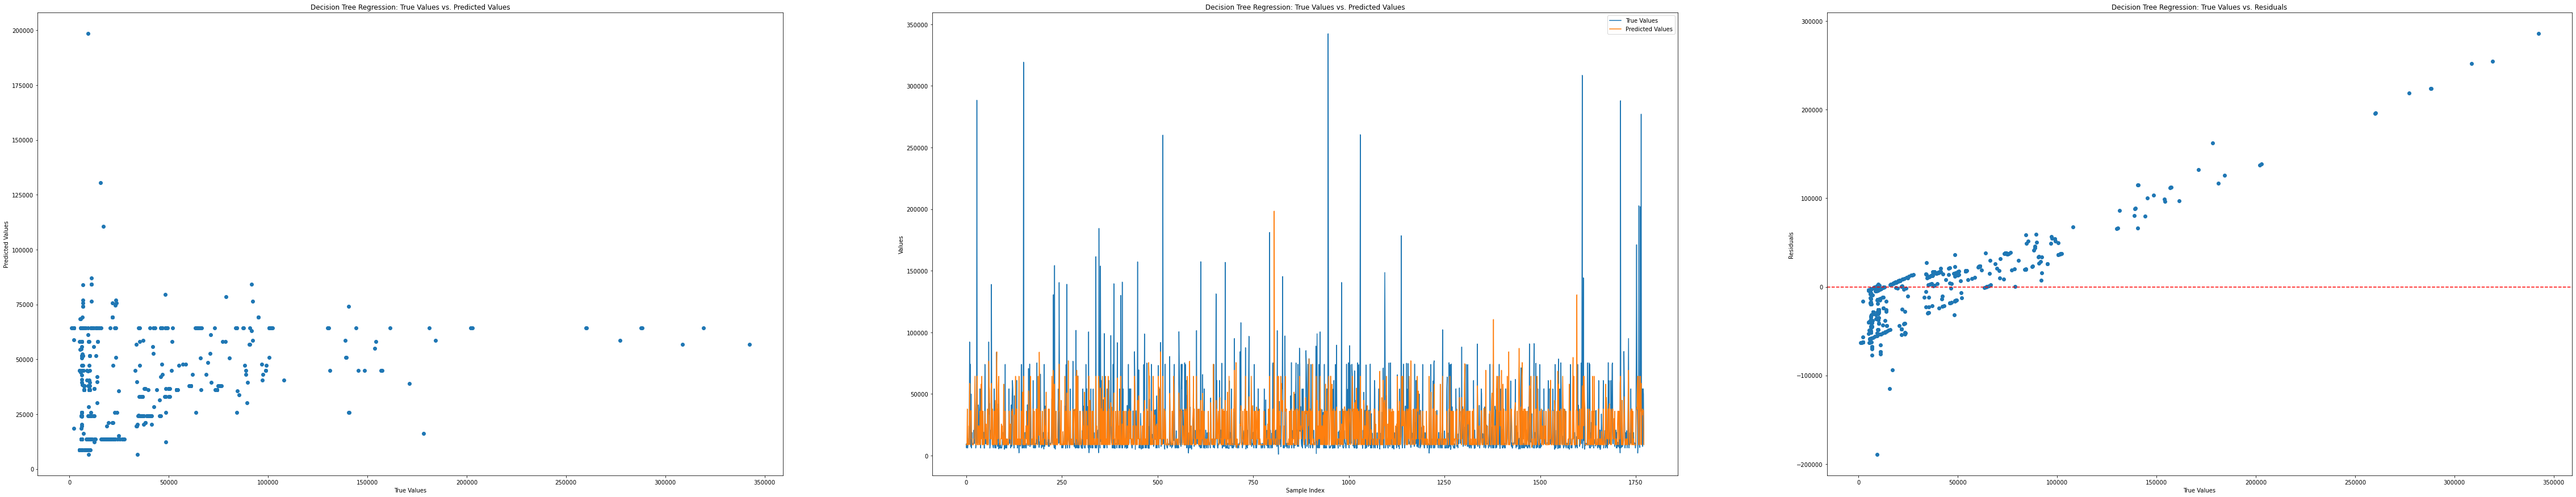

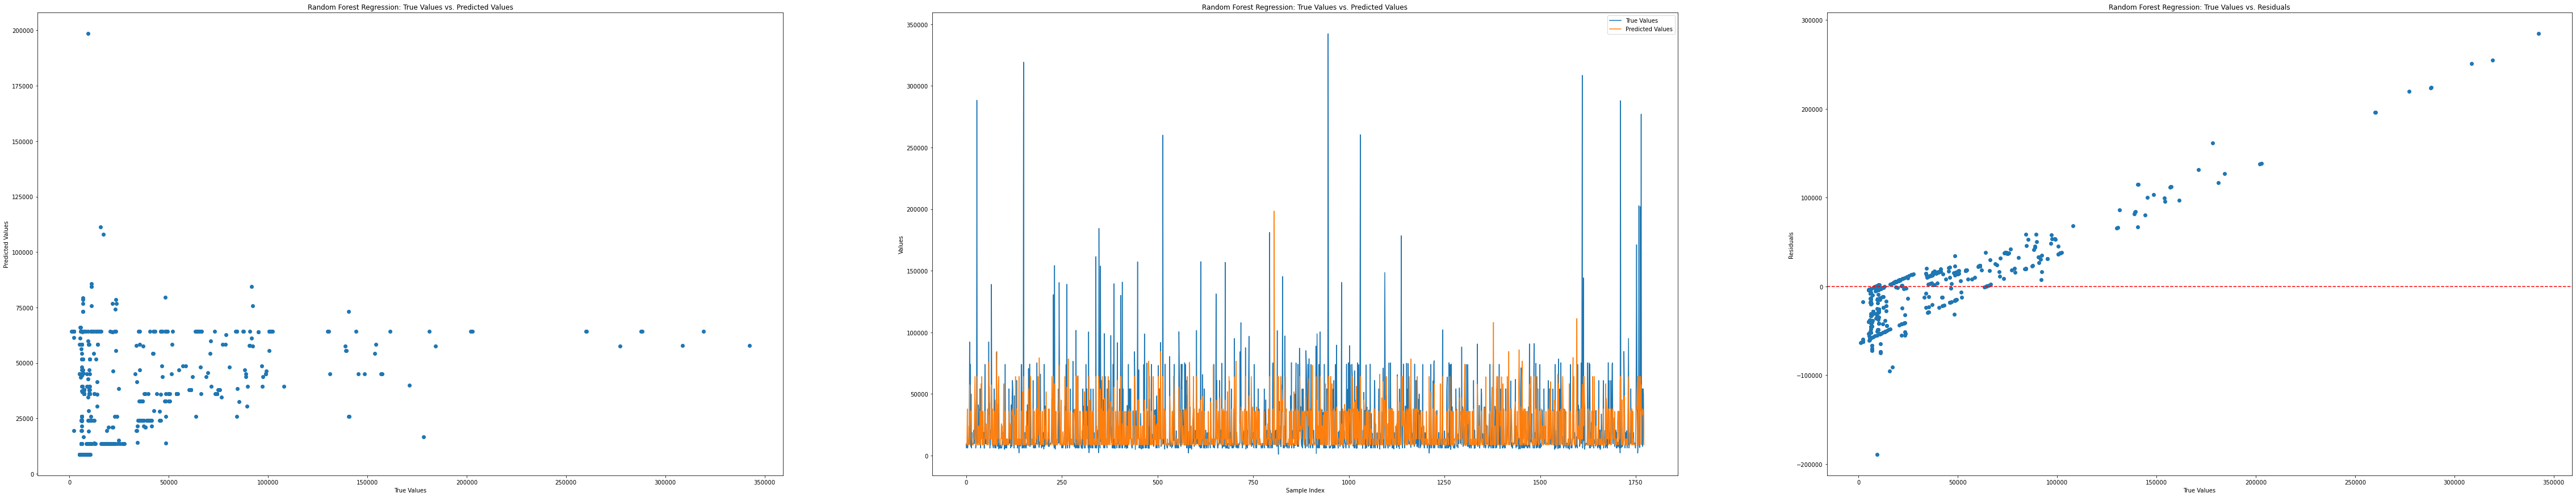

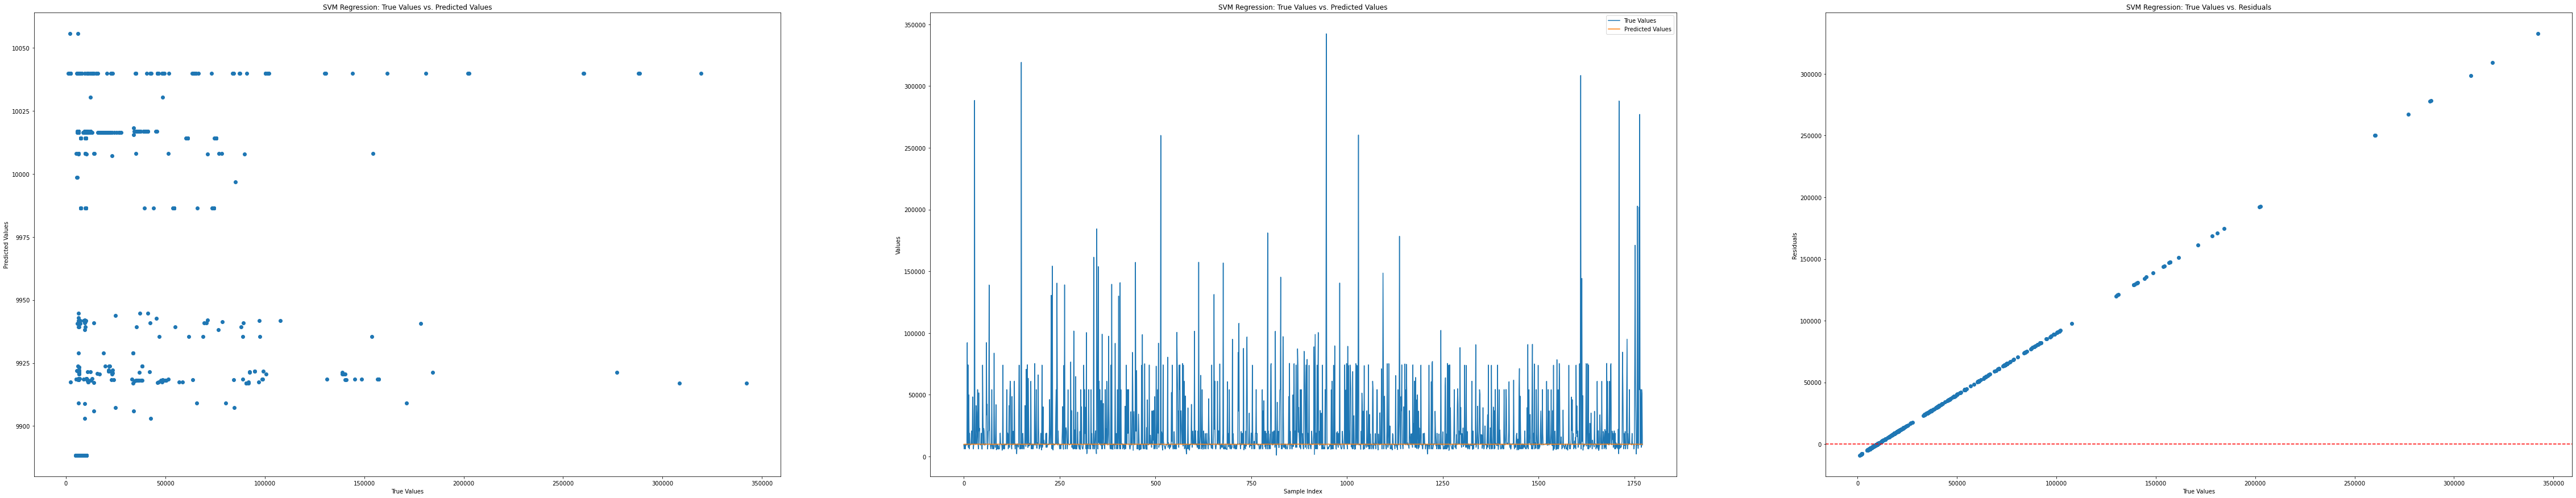

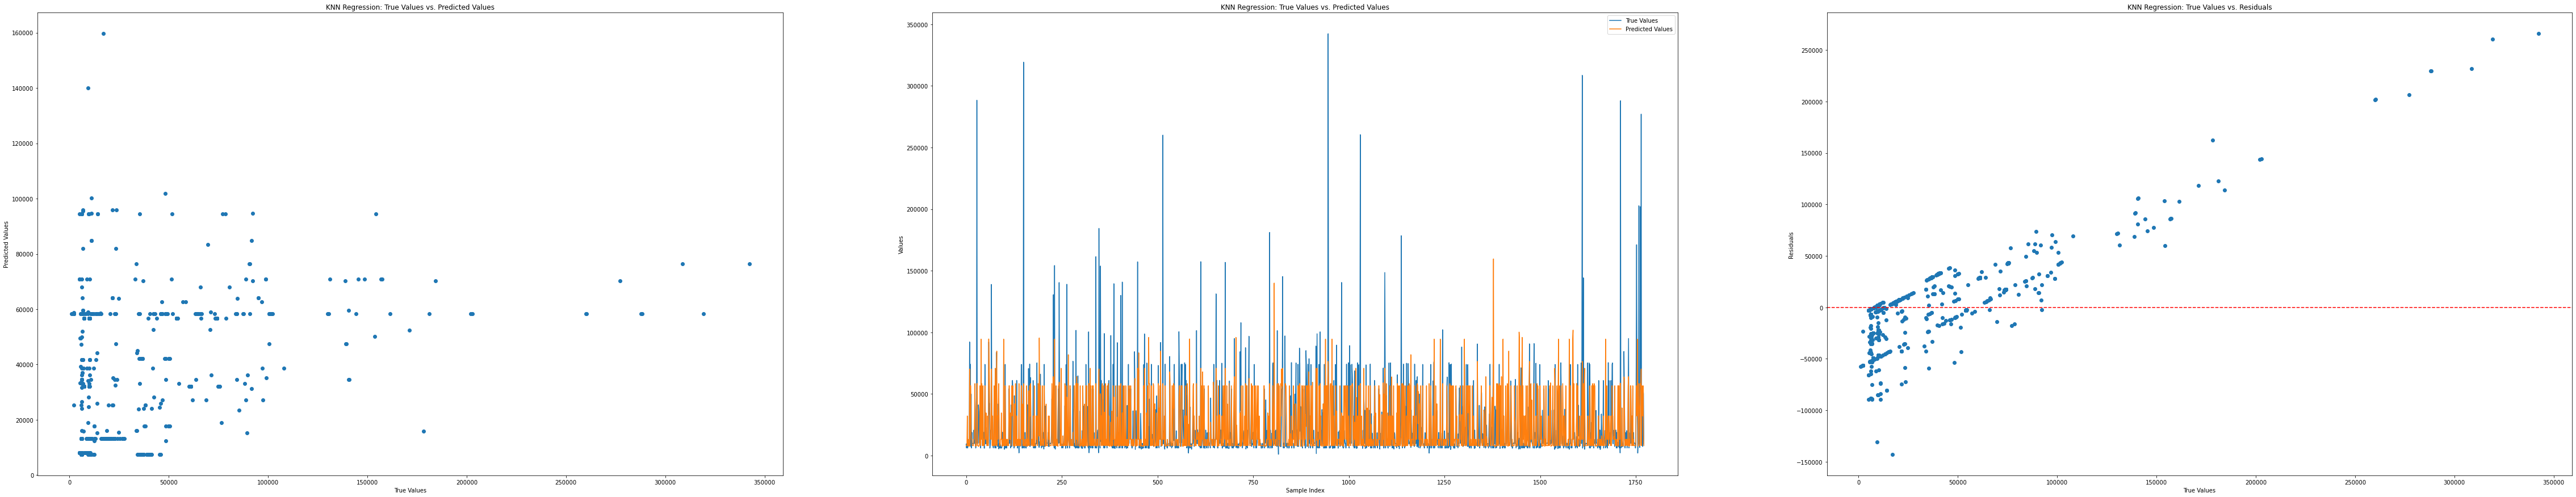

In [64]:
# 二进制编码
binary_encoded_df = pd.get_dummies(df, prefix='', prefix_sep='')
# print(binary_encoded_df)
print(binary_encoded_df.shape)
# 将二进制编码后的数据和streamCopyTriad合并
# binary_data = pd.concat([binary_encoded_df, streamCopyTriad], axis=1)
# print(binary_data.shape)

X = binary_encoded_df
y = streamCopyTriad['stream_copy']

# train(X, y)

(8858, 4)
Linear Regression MSE: 824667778.6038234
Decision Tree Regression MSE: 807971831.1696051
Random Forest Regression MSE: 807996269.8889039
Support Vector Regression MSE: 1198991801.6731613
KNN Regression MSE: 801908462.9364128


Linear Regression MAE: 14799.948268130669
Decision Tree Regression MAE: 15016.565155599897
Random Forest Regression MAE: 15024.989217336977
Support Vector Regression MAE: 14871.61063139344
KNN Regression MAE: 14848.714314522196


Linear Regression R2: 0.20705119177553633
Decision Tree Regression R2: 0.22310496756698972
Random Forest Regression R2: 0.2230814688274424
Support Vector Regression R2: -0.15287530915449765
KNN Regression R2: 0.228935122132354




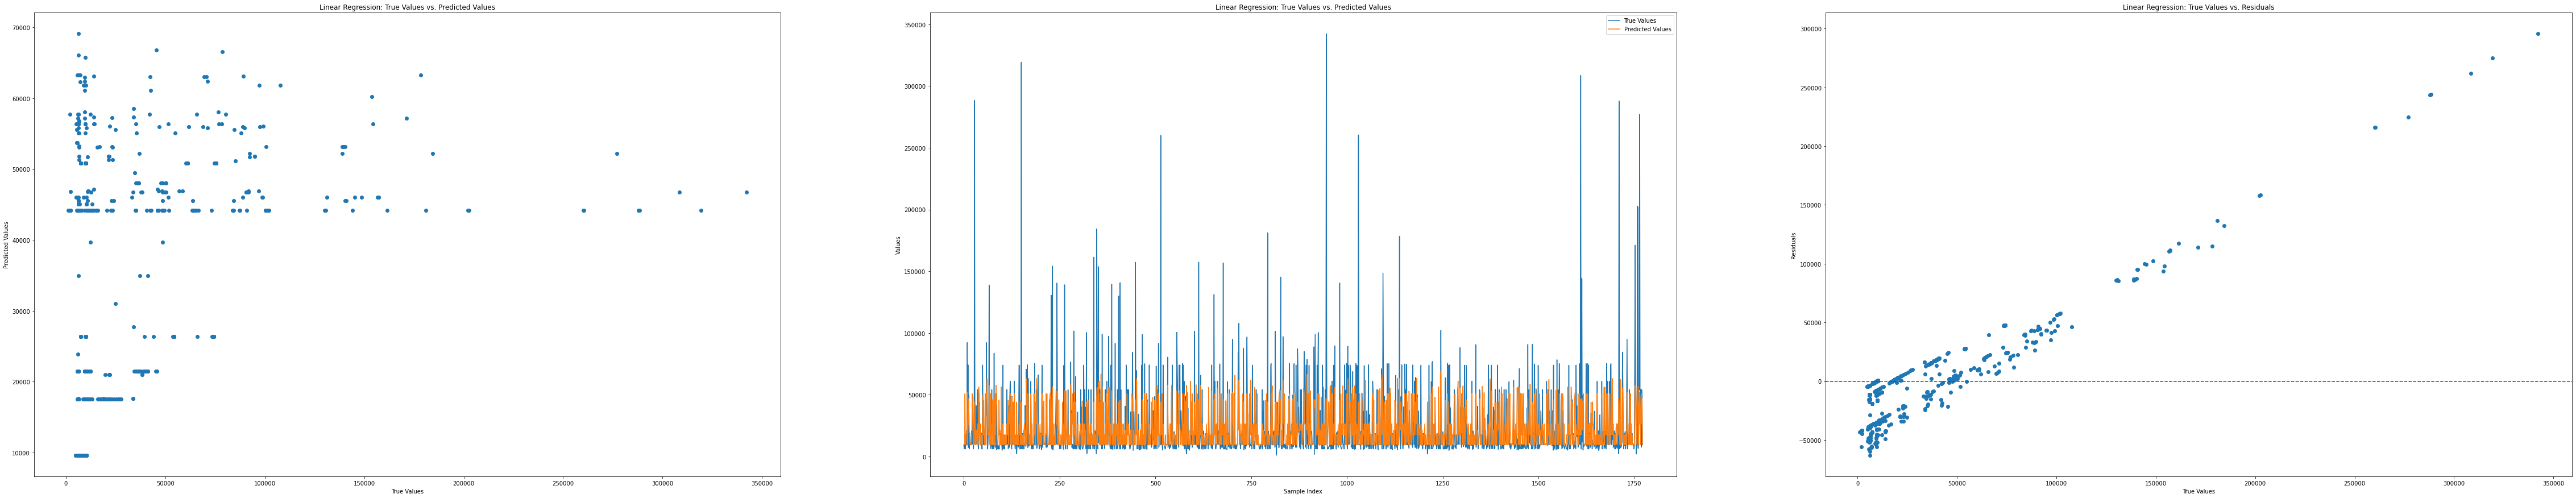

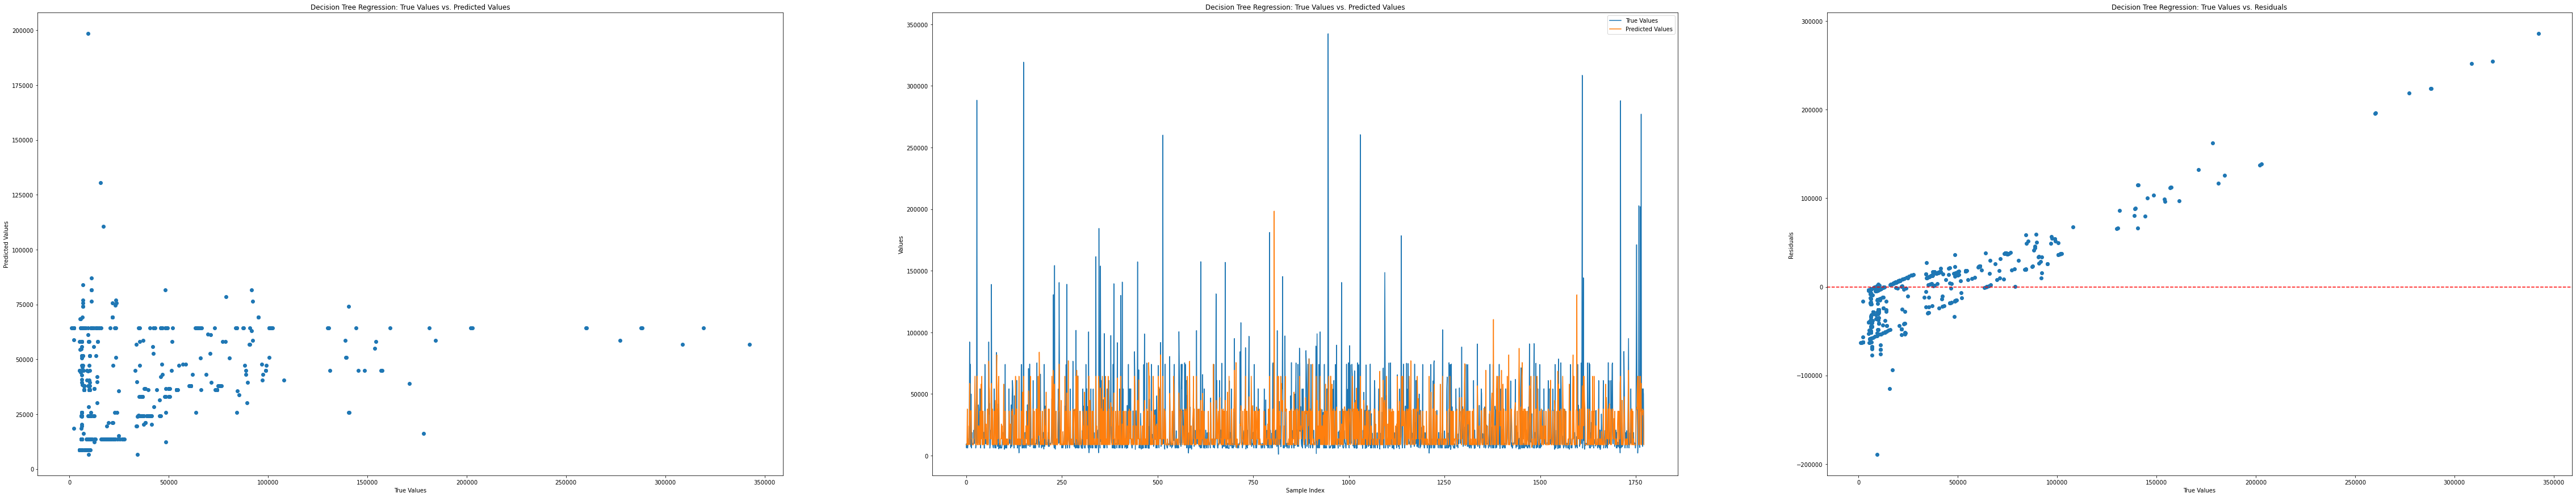

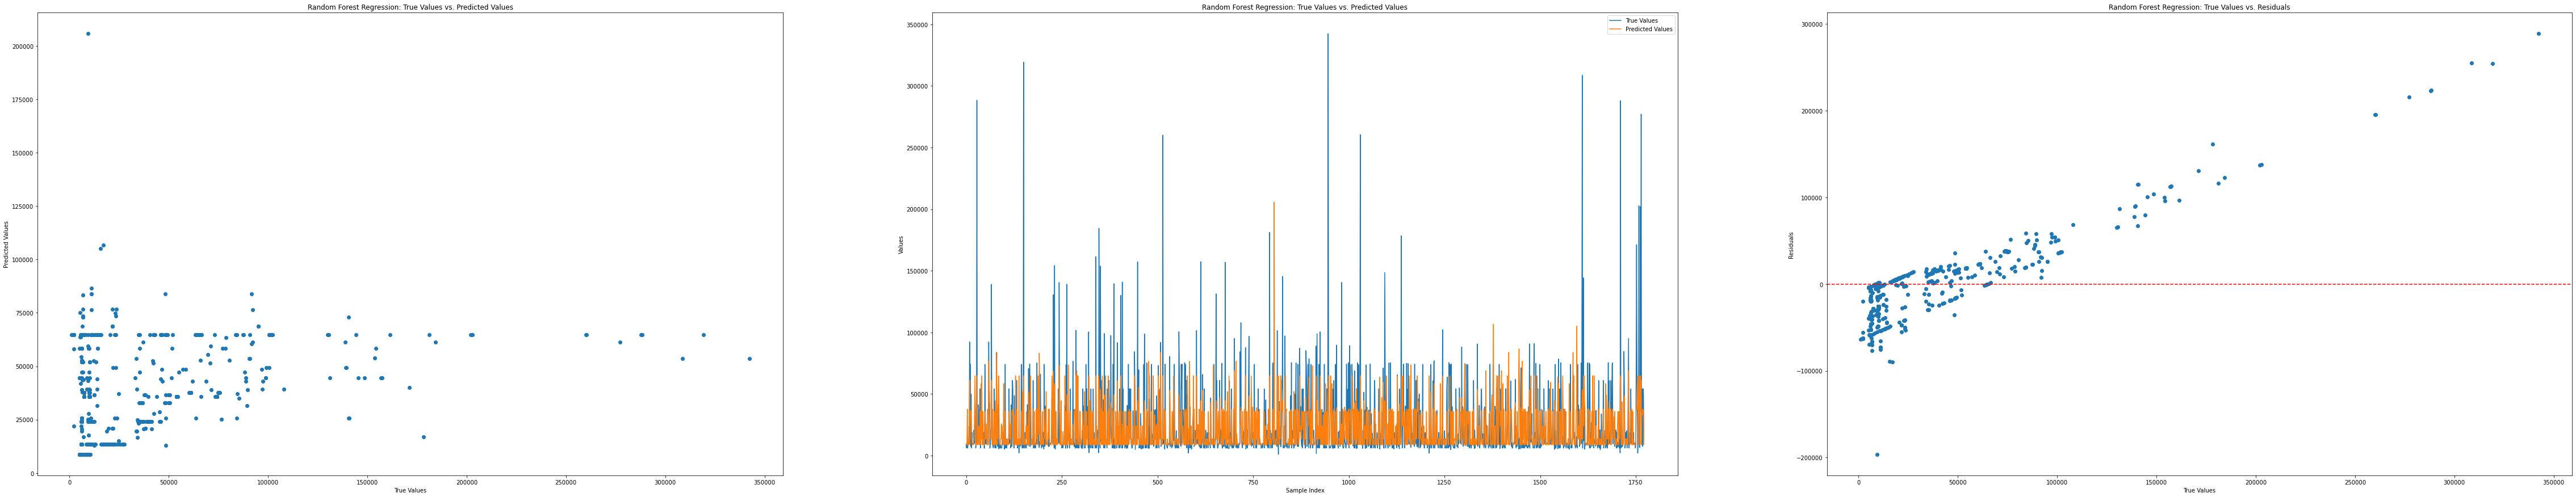

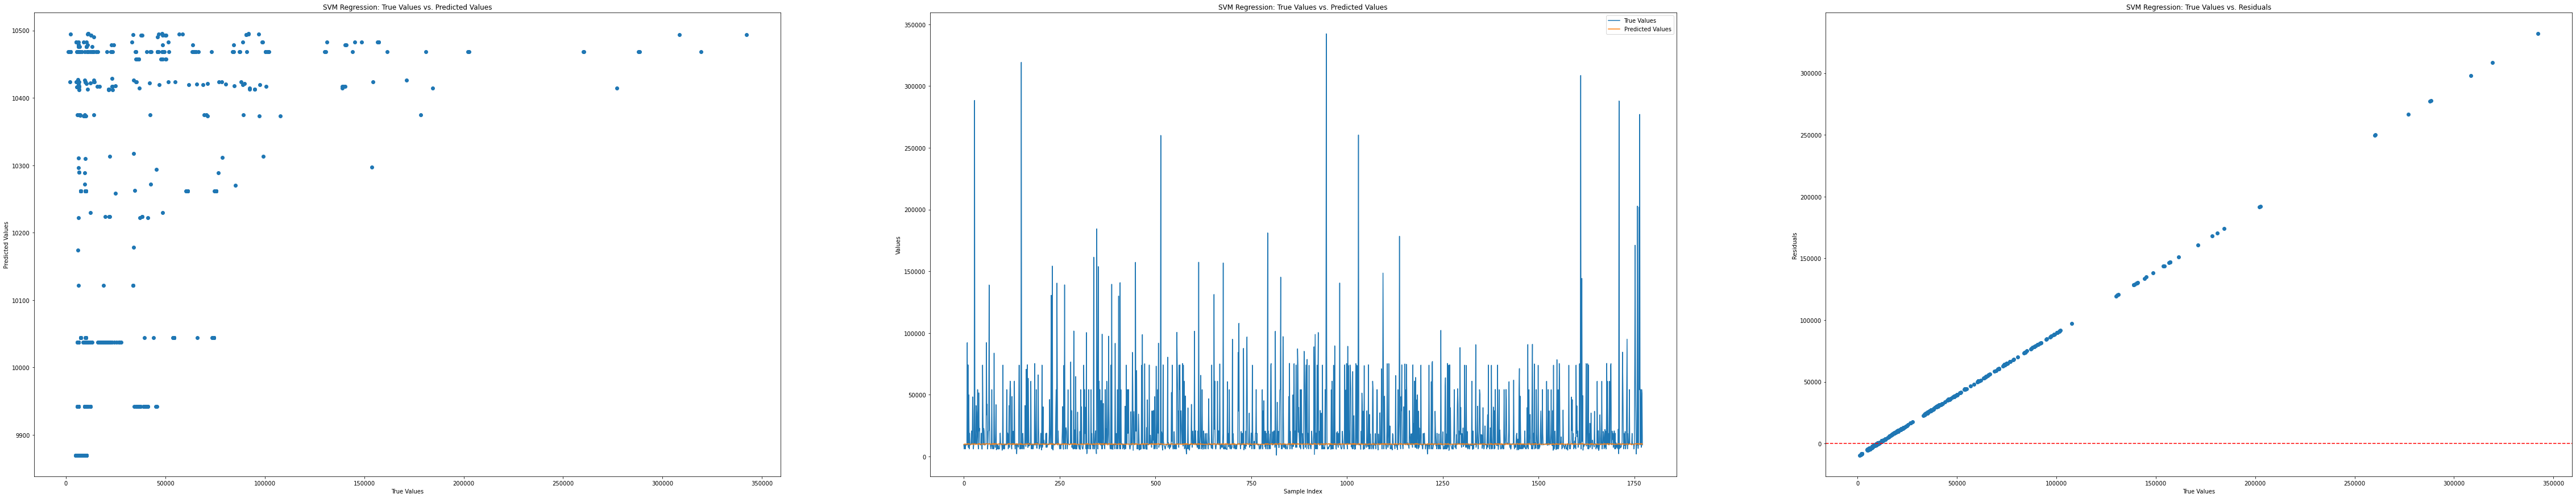

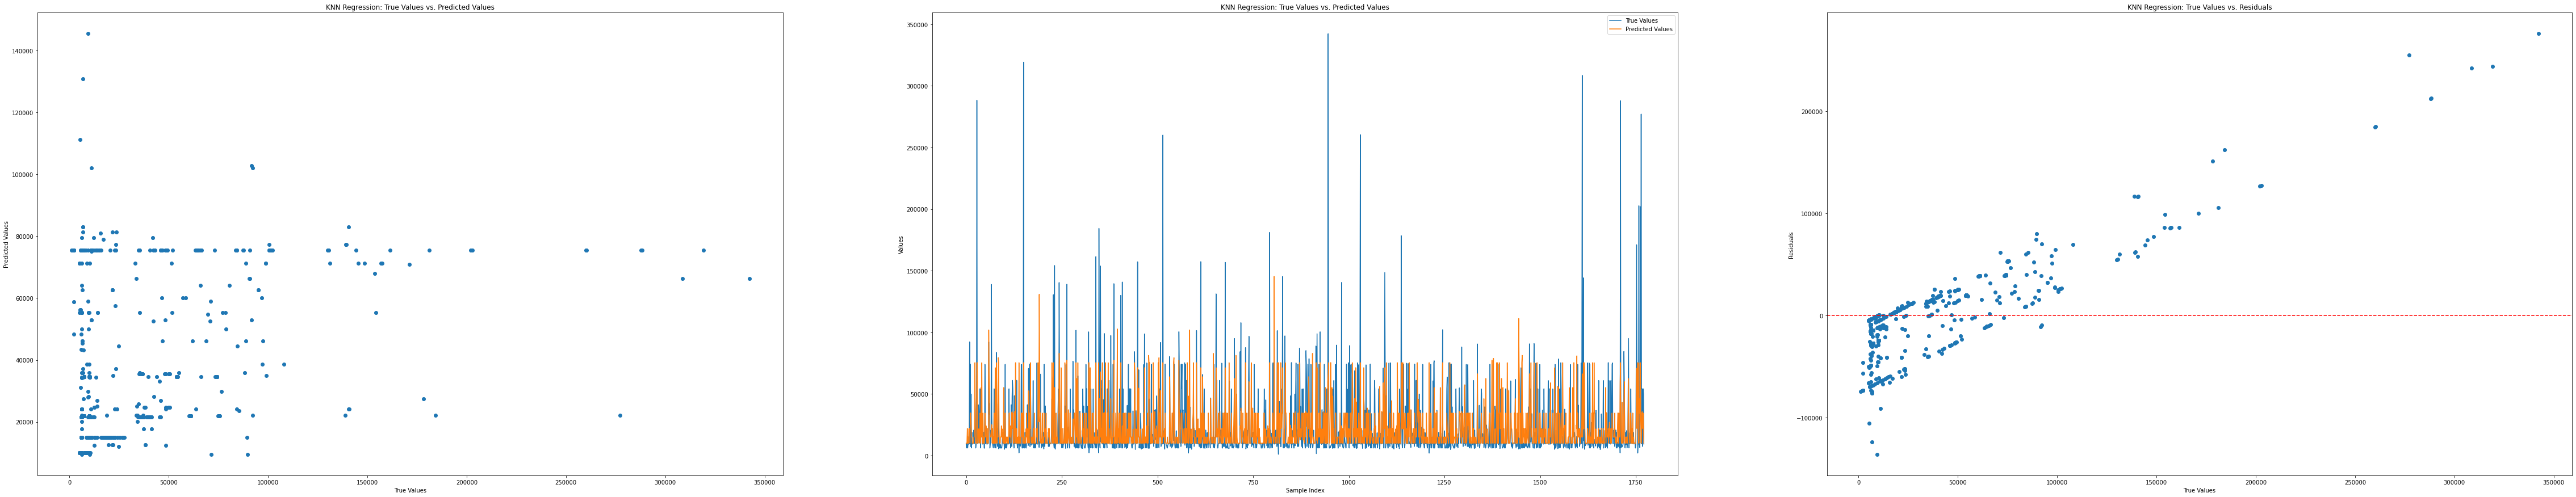

In [65]:
# 计数count编码
count_encoded_df = df.replace(df.stack().value_counts(normalize=True).to_dict())
# print(count_encoded_df)
print(count_encoded_df.shape)
# 将计数编码后的数据和streamCopyTriad合并
# count_data = pd.concat([count_encoded_df, streamCopyTriad], axis=1)
# print(count_data.shape)
# count_data.head()

X = count_encoded_df
y = streamCopyTriad['stream_copy']

# train(X, y)